In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data prep

In [ ]:
electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',
                            sep=';',
                            header=0,
                            parse_dates={'dt' : ['Date', 'Time']},
                            infer_datetime_format=True,
                            low_memory=False,
                            na_values=['nan','?'],
                            index_col='dt')

<ipython-input-4-e34ad9f770a3>:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',
<ipython-input-4-e34ad9f770a3>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',
<ipython-input-4-e34ad9f770a3>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(electricityDf.shape)
print(electricityDf.head())

(2075259, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28

In [ ]:
electricityDf.replace(['nan','?'], inplace=True)

<ipython-input-6-a6de281a0d94>:1: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  electricityDf.replace(['nan','?'], inplace=True)


In [ ]:
electricityDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
electricityDf.shape

(2075259, 7)

In [ ]:
# filling nan with mean in any columns
for j in range(0,7):
        electricityDf.iloc[:,j]=electricityDf.iloc[:,j].fillna(electricityDf.iloc[:,j].mean())

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# resampling of data over hour
df_resample = electricityDf.resample('D').mean()
df_resample.shape

(1442, 7)

In [ ]:
## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.916786   0.130732   0.315385   0.928499   0.000000   0.163965   
2   0.694252   0.426671   0.550494   0.695226   0.181857   0.345776   
3   0.431901   0.234750   0.620518   0.424618   0.095088   0.216451   
4   0.313037   0.202322   0.667476   0.311508   0.075051   0.627798   
5   0.436748   0.232377   0.686364   0.428075   0.000000   0.218680   

   var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1   0.740357  0.694252  0.426671  0.550494  0.695226  0.181857  0.345776   
2   0.536762  0.431901  0.234750  0.620518  0.424618  0.095088  0.216451   
3   0.566912  0.313037  0.202322  0.667476  0.311508  0.075051  0.627798   
4   0.218615  0.436748  0.232377  0.686364  0.428075  0.000000  0.218680   
5   0.568916  0.324670  0.182809  0.608808  0.319591  0.158084  0.216830   

    var7(t)  
1  0.536762  
2  0.566912  
3  0.218615  
4  0.568916  
5  0.407300  


In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.916786   0.130732   0.315385   0.928499   0.000000   0.163965   
2   0.694252   0.426671   0.550494   0.695226   0.181857   0.345776   
3   0.431901   0.234750   0.620518   0.424618   0.095088   0.216451   
4   0.313037   0.202322   0.667476   0.311508   0.075051   0.627798   
5   0.436748   0.232377   0.686364   0.428075   0.000000   0.218680   

   var7(t-1)   var1(t)  
1   0.740357  0.694252  
2   0.536762  0.431901  
3   0.566912  0.313037  
4   0.218615  0.436748  
5   0.568916  0.324670  


In [ ]:
print(reframed.shape)

(1441, 8)


In [ ]:
reframed = reframed.reset_index(drop=True)
values = reframed.values

In [ ]:
print(values.shape)

(1441, 8)


In [ ]:
len(values)

1441

In [ ]:
train, test = train_test_split(values, train_size=0.9, test_size=0.1, random_state=50, shuffle=False)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=50, shuffle=False)

In [ ]:
print(train.shape)
print(test.shape)
print(val.shape)

(1036, 8)
(145, 8)
(260, 8)


In [ ]:
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(val_X.shape, val_y.shape)

(1036, 1, 7) (1036,) (145, 1, 7) (145,)
(260, 1, 7) (260,)


transformer model implementation

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
  x = keras.layers.Dropout(dropout)(x)
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  res = x + inputs

  x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
  x = keras.layers.Dropout(dropout)(x)
  x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  return x + res

In [ ]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
  inputs = keras.layers.Input(shape=input_shape)
  x = inputs
  for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

  x = keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
  for dim in mlp_units:
    x = keras.layers.Dense(dim, activation='relu')(x)
    x = keras.layers.Dropout(mlp_dropout)(x)
  outputs = keras.layers.Dense(1)(x)

  return keras.Model(inputs, outputs)

In [ ]:
model = build_model(
  input_shape=(1,7),
  head_size=256,
  num_heads=4,
  ff_dim=4,
  num_transformer_blocks=4,
  mlp_units=[128],
  mlp_dropout=0.4,
  dropout=0.25
)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model training

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Train the model
history = model.fit(
  train_X, train_y,
  validation_data=(val_X, val_y),
  epochs=50,
  batch_size=32,
  callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
  verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0923 - mae: 0.2651 - val_loss: 0.0137 - val_mae: 0.0904
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0206 - mae: 0.1120 - val_loss: 0.0094 - val_mae: 0.0738
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0190 - mae: 0.1036 - val_loss: 0.0087 - val_mae: 0.0723
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0173 - mae: 0.1018 - val_loss: 0.0082 - val_mae: 0.0713
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0163 - mae: 0.1003 - val_loss: 0.0085 - val_mae: 0.0717
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0163 - mae: 0.0986 - val_loss: 0.0081 - val_mae: 0.0703
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143 - mae: 0.0921 - val_loss: 0.0077 - val_mae: 0.0693
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0139 - mae: 0.0902 - val_loss: 0.0071 - val_mae: 0.0650
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0126 - mae: 0

In [ ]:
test_loss = model.evaluate(test_X, test_y)
print(f"Test Loss: {test_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mae: 0.0562 
Test Loss: 0.0060


In [ ]:
pred_y_test = model.predict(test_X)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

# Define representative dataset generator function
def representative_data_gen():
    # Step 1: Use your raw dataset (e.g., test data here for simplicity)
    raw_data = df_resample.values  # Use the same resampled dataset as in preprocessing
    raw_data = raw_data.astype('float32')  # Ensure correct data type

    # Step 2: Apply scaling (use the same MinMaxScaler from training)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(raw_data)

    # Step 3: Convert to supervised format (same as training)
    reframed = series_to_supervised(scaled_data, 1, 1)
    reframed.drop(reframed.columns[[8, 9, 10, 11, 12, 13]], axis=1, inplace=True)  # Drop unwanted columns

    # Step 4: Prepare input features
    values = reframed.values
    inputs = values[:, :-1]  # Use input features only (exclude output labels)

    # Step 5: Reshape into 3D format (samples, timesteps, features)
    inputs = inputs.reshape((inputs.shape[0], 1, inputs.shape[1]))

    # Step 6: Yield batched inputs as required by TensorFlow Lite
    for i in range(inputs.shape[0]):
        yield [inputs[i]]

In [ ]:
# Add post-training quantization code here
import os

# Step 1: Specify the folder to save the quantized model
quantized_model_folder = "/content/drive/MyDrive/PES/quantized_models"
os.makedirs(quantized_model_folder, exist_ok=True)

# Step 2: Convert the trained model to TensorFlow Lite format with int8 quantization
def convert_to_tflite(model, save_folder, model_name="int8_quantized_og_model.tflite"):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Enable int8 quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen  # You need to define this function

    # Ensure that only integer operations are used
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

    # Convert the model
    tflite_model = converter.convert()

    # Save the quantized model to the specified folder
    quantized_model_path = os.path.join(save_folder, model_name)
    with open(quantized_model_path, "wb") as f:
        f.write(tflite_model)

    print(f"Quantized model saved at: {quantized_model_path}")
    return quantized_model_path

# Step 3: Call the function to convert and save the model
quantized_model_path = convert_to_tflite(model, quantized_model_folder)

Saved artifact at '/tmp/tmp3sgs9ugp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137169797688464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797689616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797686736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797686352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797690000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797689424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797690576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797690960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797691728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797689808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797692688: Tens

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model saved at: /content/drive/MyDrive/PES/quantized_models/int8_quantized_og_model.tflite


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


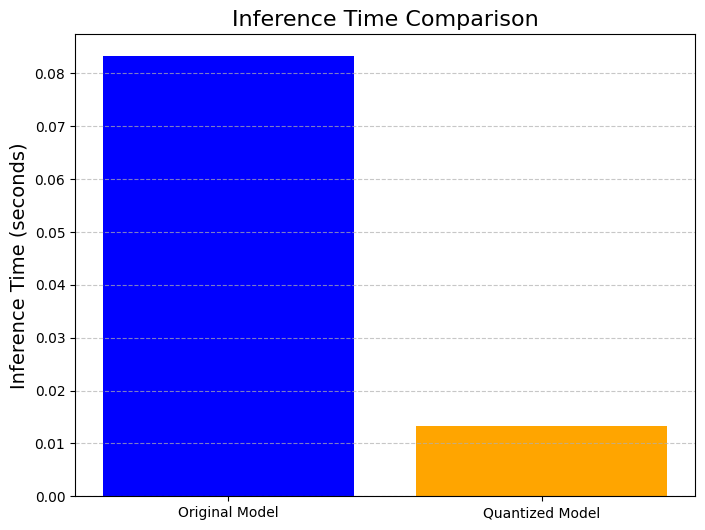

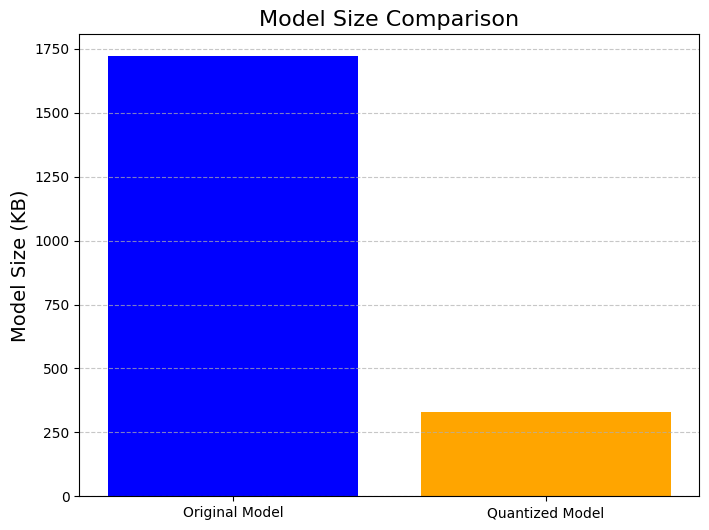

Original Model Inference Time: 0.0832 seconds
Quantized Model Inference Time: 0.0133 seconds
Original Model Size: 1720.89 KB
Quantized Model Size: 330.48 KB


In [ ]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Measure inference time for the original model
def measure_inference_time_original(model, test_X):
    start_time = time.time()
    model.predict(test_X)
    end_time = time.time()
    return end_time - start_time

# Measure inference time for the int8 quantized model
def measure_inference_time_quantized(tflite_model_path, test_X):
    # Load the quantized model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Ensure input data is in the correct format for int8
    input_scale, input_zero_point = input_details[0]['quantization']
    test_X = (test_X / input_scale + input_zero_point).astype(np.uint8)

    # Measure inference time
    start_time = time.time()
    for i in range(test_X.shape[0]):
        input_data = np.expand_dims(test_X[i], axis=0)  # Add batch dimension
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details[0]['index'])
    end_time = time.time()

    return end_time - start_time

# Compare model sizes
def get_model_size(file_path):
    return os.path.getsize(file_path) / 1024  # Size in KB

# Graph for inference time comparison
def plot_inference_time(original_time, quantized_time):
    labels = ['Original Model', 'Quantized Model']
    times = [original_time, quantized_time]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, times, color=['blue', 'orange'])
    plt.ylabel('Inference Time (seconds)', fontsize=14)
    plt.title('Inference Time Comparison', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Graph for model size comparison
def plot_model_size(original_size, quantized_size):
    labels = ['Original Model', 'Quantized Model']
    sizes = [original_size, quantized_size]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, sizes, color=['blue', 'orange'])
    plt.ylabel('Model Size (KB)', fontsize=14)
    plt.title('Model Size Comparison', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Integrate the comparisons
original_model_path = "original_model.keras"  # Save the original model to this path
quantized_model_path = os.path.join(quantized_model_folder, "int8_quantized_og_model.tflite")  # Updated for int8

# Save the original model
model.save(original_model_path)

# Measure inference time
original_time = measure_inference_time_original(model, test_X)
quantized_time = measure_inference_time_quantized(quantized_model_path, test_X)

# Get model sizes
original_size = get_model_size(original_model_path)
quantized_size = get_model_size(quantized_model_path)

# Plot the two separate graphs
plot_inference_time(original_time, quantized_time)
plot_model_size(original_size, quantized_size)

# Print raw values for reference
print(f"Original Model Inference Time: {original_time:.4f} seconds")
print(f"Quantized Model Inference Time: {quantized_time:.4f} seconds")
print(f"Original Model Size: {original_size:.2f} KB")
print(f"Quantized Model Size: {quantized_size:.2f} KB")

In [ ]:
def load_and_predict_tflite_model(tflite_model_path, test_X):
    # Load the quantized model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Get input and output quantization parameters (scale and zero-point)
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    # Ensure input data is in the correct format for int8
    test_X = (test_X / input_scale + input_zero_point).astype(np.uint8)

    # Perform inference
    predictions = []
    for i in range(test_X.shape[0]):
        input_data = np.expand_dims(test_X[i], axis=0)  # Add batch dimension
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Dequantize output data back to floating-point format
        dequantized_output = (output_data - output_zero_point) * output_scale
        predictions.append(dequantized_output[0])

    return np.array(predictions)

# Generate predictions with the quantized model
quantized_model_predictions = load_and_predict_tflite_model(quantized_model_path, test_X)

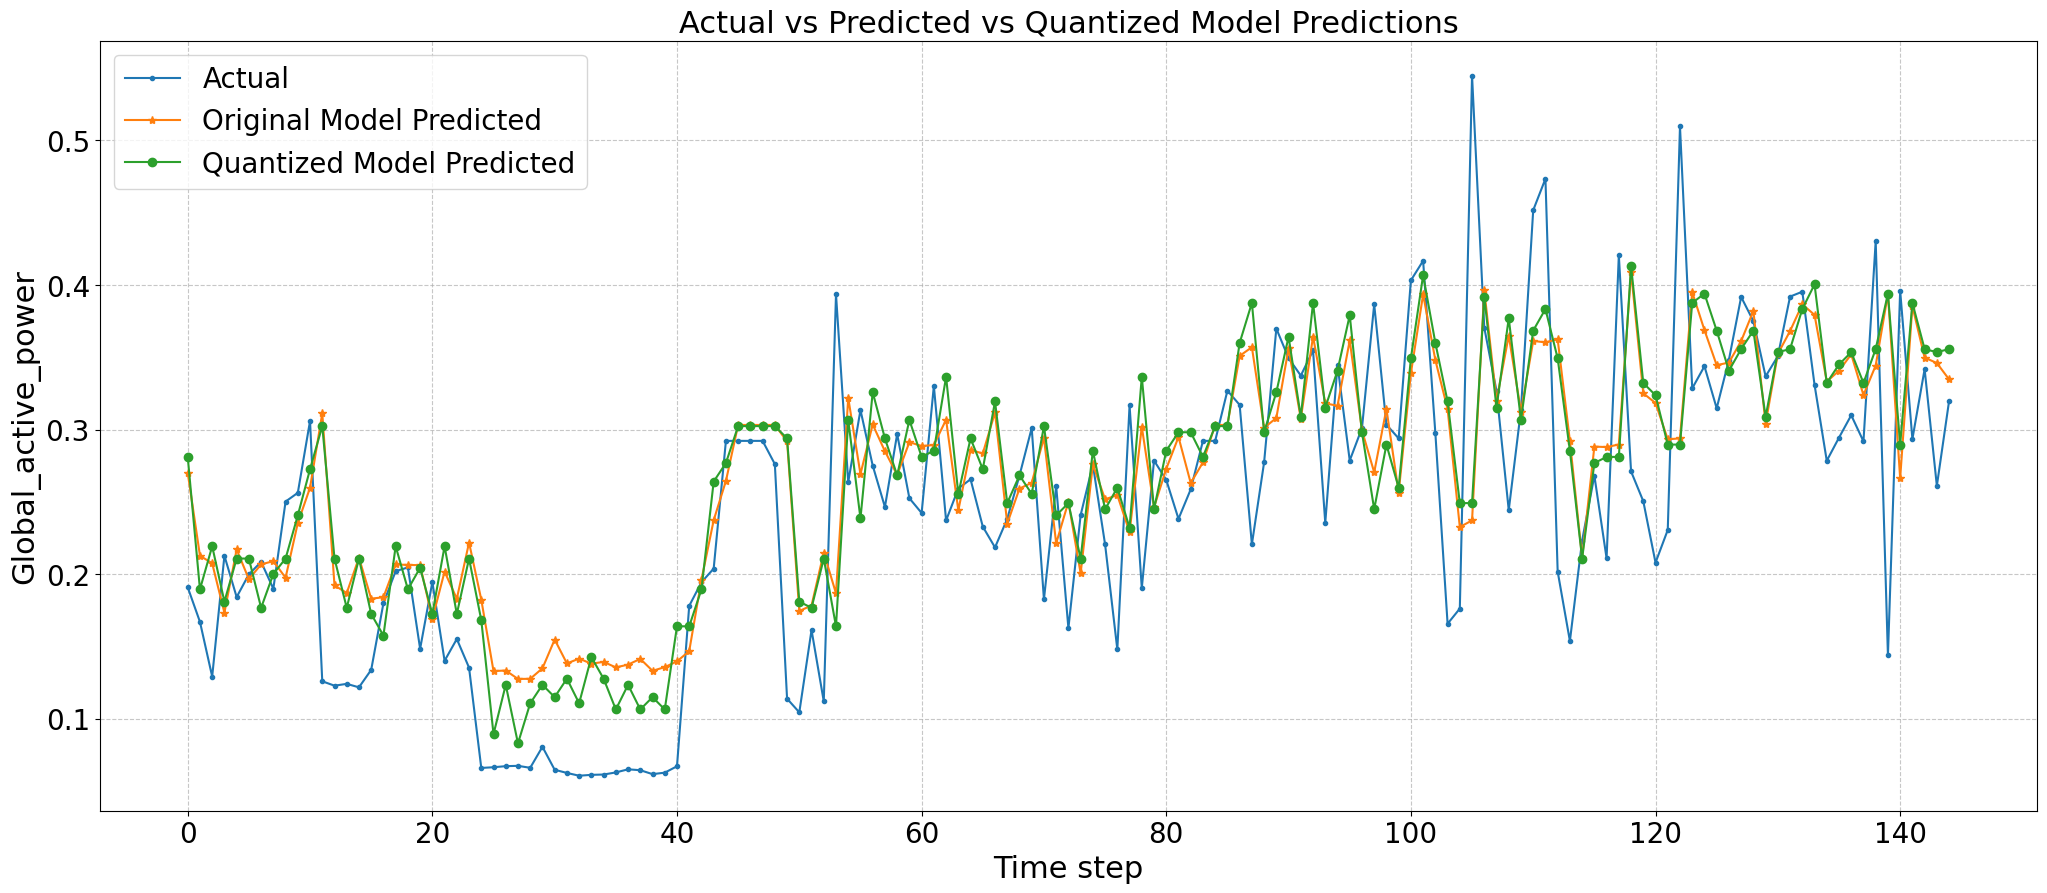

Actual Values (first 5): [0.191 0.167 0.129 0.213 0.184]
Original Model Predictions (first 5): [[0.27 ]
 [0.213]
 [0.208]
 [0.173]
 [0.217]]
Quantized Model Predictions (first 5): [[0.281]
 [0.19 ]
 [0.219]
 [0.181]
 [0.211]]
Prediction Differences (first 5): [[-0.011]
 [ 0.023]
 [-0.012]
 [-0.008]
 [ 0.006]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting Actual vs Predicted vs Quantized Model Predictions
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Predicted vs Quantized Model Predictions", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot actual values
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")

# Plot original model predictions
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Original Model Predicted")

# Plot quantized model predictions
plt.plot(range(len(quantized_model_predictions)), quantized_model_predictions[:], marker="o", label="Quantized Model Predicted")

# Add gridlines for better visualization
plt.grid(linestyle='--', alpha=0.7)

# Add legend and show the plot
plt.legend(fontsize=20)
plt.show()

# Print first few actual values, original predictions, and quantized predictions
print("Actual Values (first 5):", np.round(test_y[:5], 3))  # Rounded for readability
print("Original Model Predictions (first 5):", np.round(pred_y_test[:5], 3))
print("Quantized Model Predictions (first 5):", np.round(quantized_model_predictions[:5], 3))

# Check for differences between original and quantized predictions
diff = pred_y_test - quantized_model_predictions
print("Prediction Differences (first 5):", np.round(diff[:5], 3))  # Rounded for readability

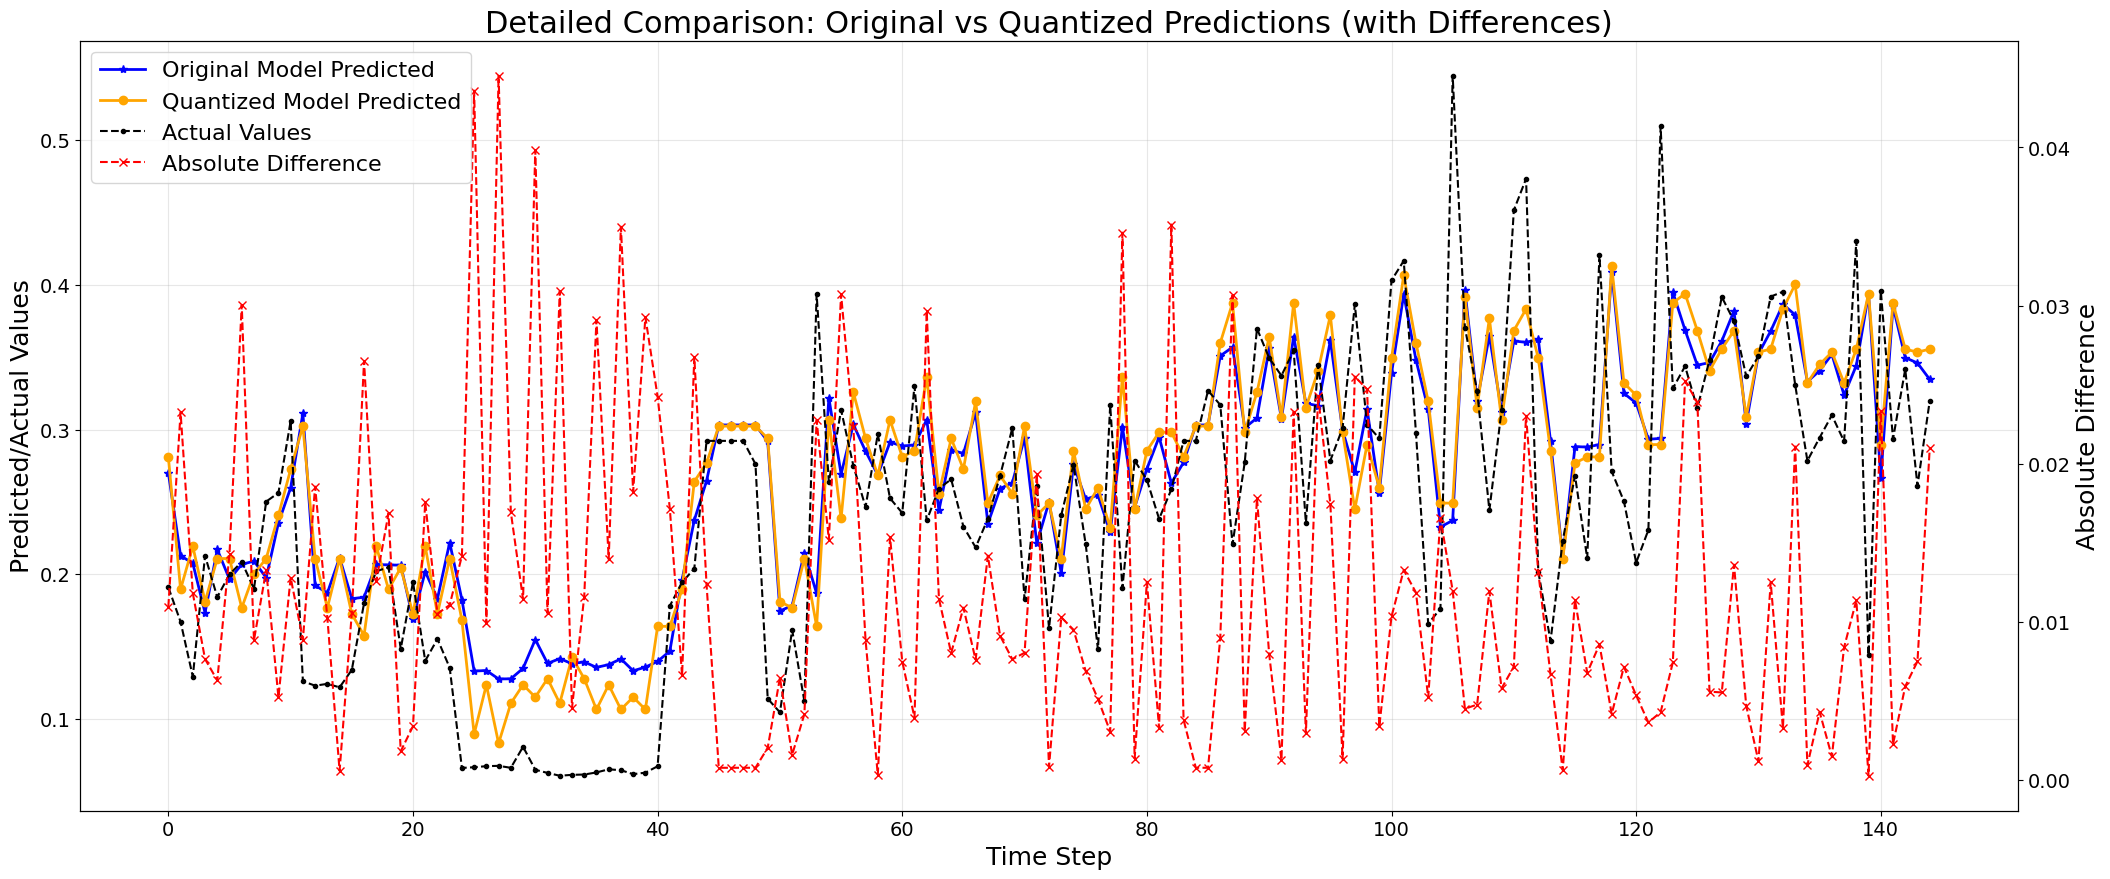

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten predictions for consistency and perform absolute differences
pred_y_test_flat = pred_y_test.flatten()
quantized_model_predictions_flat = quantized_model_predictions.flatten()
diff = np.abs(pred_y_test_flat - quantized_model_predictions_flat)

# Create a figure with a secondary y-axis for the differences
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot the original model predictions
ax1.plot(range(len(pred_y_test_flat)), pred_y_test_flat,
         marker="*", label="Original Model Predicted",
         color="blue", linewidth=2)

# Plot the quantized model predictions
ax1.plot(range(len(quantized_model_predictions_flat)), quantized_model_predictions_flat,
         marker="o", label="Quantized Model Predicted",
         color="orange", linewidth=2)

# Plot actual values
ax1.plot(range(len(test_y)), test_y,
         marker=".", label="Actual Values",
         color="black", linestyle="--", linewidth=1.5)

# Label the primary y-axis
ax1.set_ylabel('Predicted/Actual Values', fontsize=18)
ax1.set_xlabel('Time Step', fontsize=18)

# Add a secondary y-axis for the differences
ax2 = ax1.twinx()
ax2.plot(range(len(diff)), diff,
         marker="x", label="Absolute Difference",
         color="red", linestyle="--", linewidth=1.5)
ax2.set_ylabel('Absolute Difference', fontsize=18)

# Add a title and grid
plt.title("Detailed Comparison: Original vs Quantized Predictions (with Differences)", fontsize=22)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc="upper left")

# Adjust tick sizes
ax1.tick_params(axis="both", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

# Show the plot
plt.show()

In [ ]:
# Inspect the int8 quantized model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/PES/quantized_models/int8_quantized_og_model.tflite")
interpreter.allocate_tensors()

# Print input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:")
for detail in input_details:
    print(f"  Name: {detail['name']}")
    print(f"  Shape: {detail['shape']}")
    print(f"  Data Type: {detail['dtype']}")
    print(f"  Quantization (Scale, Zero Point): {detail['quantization']}")
    print("-" * 50)

print("Output Details:")
for detail in output_details:
    print(f"  Name: {detail['name']}")
    print(f"  Shape: {detail['shape']}")
    print(f"  Data Type: {detail['dtype']}")
    print(f"  Quantization (Scale, Zero Point): {detail['quantization']}")
    print("-" * 50)

Input Details:
  Name: serving_default_keras_tensor:0
  Shape: [1 1 7]
  Data Type: <class 'numpy.uint8'>
  Quantization (Scale, Zero Point): (0.003921568859368563, 0)
--------------------------------------------------
Output Details:
  Name: StatefulPartitionedCall_1:0
  Shape: [1 1]
  Data Type: <class 'numpy.uint8'>
  Quantization (Scale, Zero Point): (0.0021297046914696693, 0)
--------------------------------------------------


Transformer Model MAE (Original): 0.058319351751
Transformer Model MAE (Quantized): 0.058271434061
Transformer Model RMSE (Original): 0.077555049229
Transformer Model RMSE (Quantized): 0.077987298068
Transformer Model MSE (Original): 0.006014785661
Transformer Model MSE (Quantized): 0.006082018660


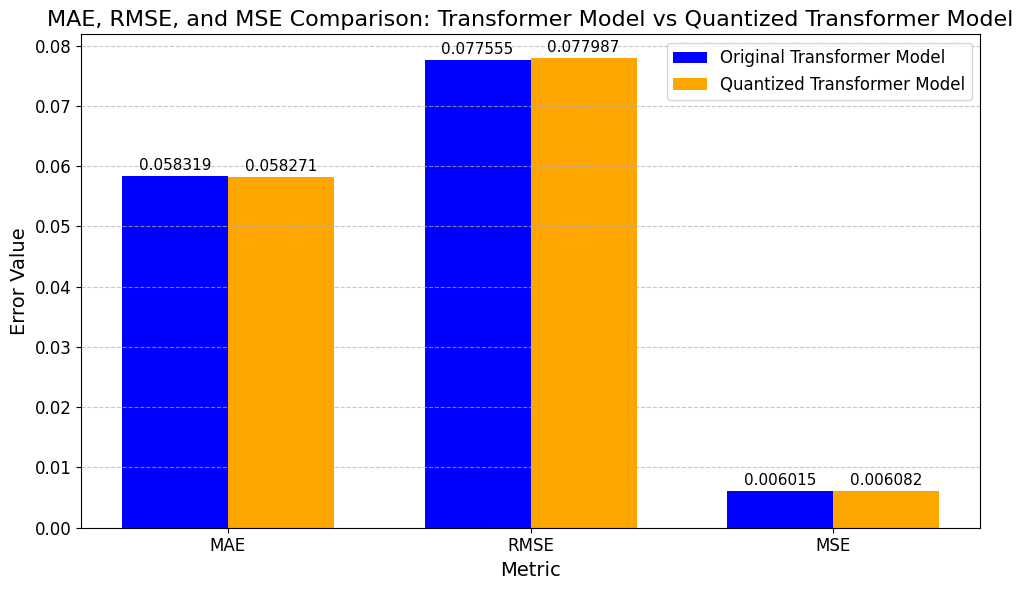

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate MAE, RMSE, and MSE for the transformer model
mae_original = mean_absolute_error(test_y, pred_y_test.flatten())
mae_quantized = mean_absolute_error(test_y, quantized_model_predictions.flatten())

rmse_original = np.sqrt(mean_squared_error(test_y, pred_y_test.flatten()))
rmse_quantized = np.sqrt(mean_squared_error(test_y, quantized_model_predictions.flatten()))

mse_original = mean_squared_error(test_y, pred_y_test.flatten())
mse_quantized = mean_squared_error(test_y, quantized_model_predictions.flatten())

# Print the MAE, RMSE, and MSE values with high precision for the console (10+ decimal places)
print(f"Transformer Model MAE (Original): {mae_original:.12f}")
print(f"Transformer Model MAE (Quantized): {mae_quantized:.12f}")
print(f"Transformer Model RMSE (Original): {rmse_original:.12f}")
print(f"Transformer Model RMSE (Quantized): {rmse_quantized:.12f}")
print(f"Transformer Model MSE (Original): {mse_original:.12f}")
print(f"Transformer Model MSE (Quantized): {mse_quantized:.12f}")

# Data for the bar graph
metrics = ['MAE', 'RMSE', 'MSE']
original_values = [mae_original, rmse_original, mse_original]
quantized_values = [mae_quantized, rmse_quantized, mse_quantized]

# Create a grouped bar graph for MAE, RMSE, and MSE
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_values, width, label='Original Transformer Model', color='blue')
bars2 = ax.bar(x + width/2, quantized_values, width, label='Quantized Transformer Model', color='orange')

# Add labels and title
ax.set_ylabel('Error Value', fontsize=14)
ax.set_xlabel('Metric', fontsize=14)
ax.set_title('MAE, RMSE, and MSE Comparison: Transformer Model vs Quantized Transformer Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Add gridlines for better visualization
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars (6 decimal places for precision)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f"{height:.6f}", ha='center', fontsize=11)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

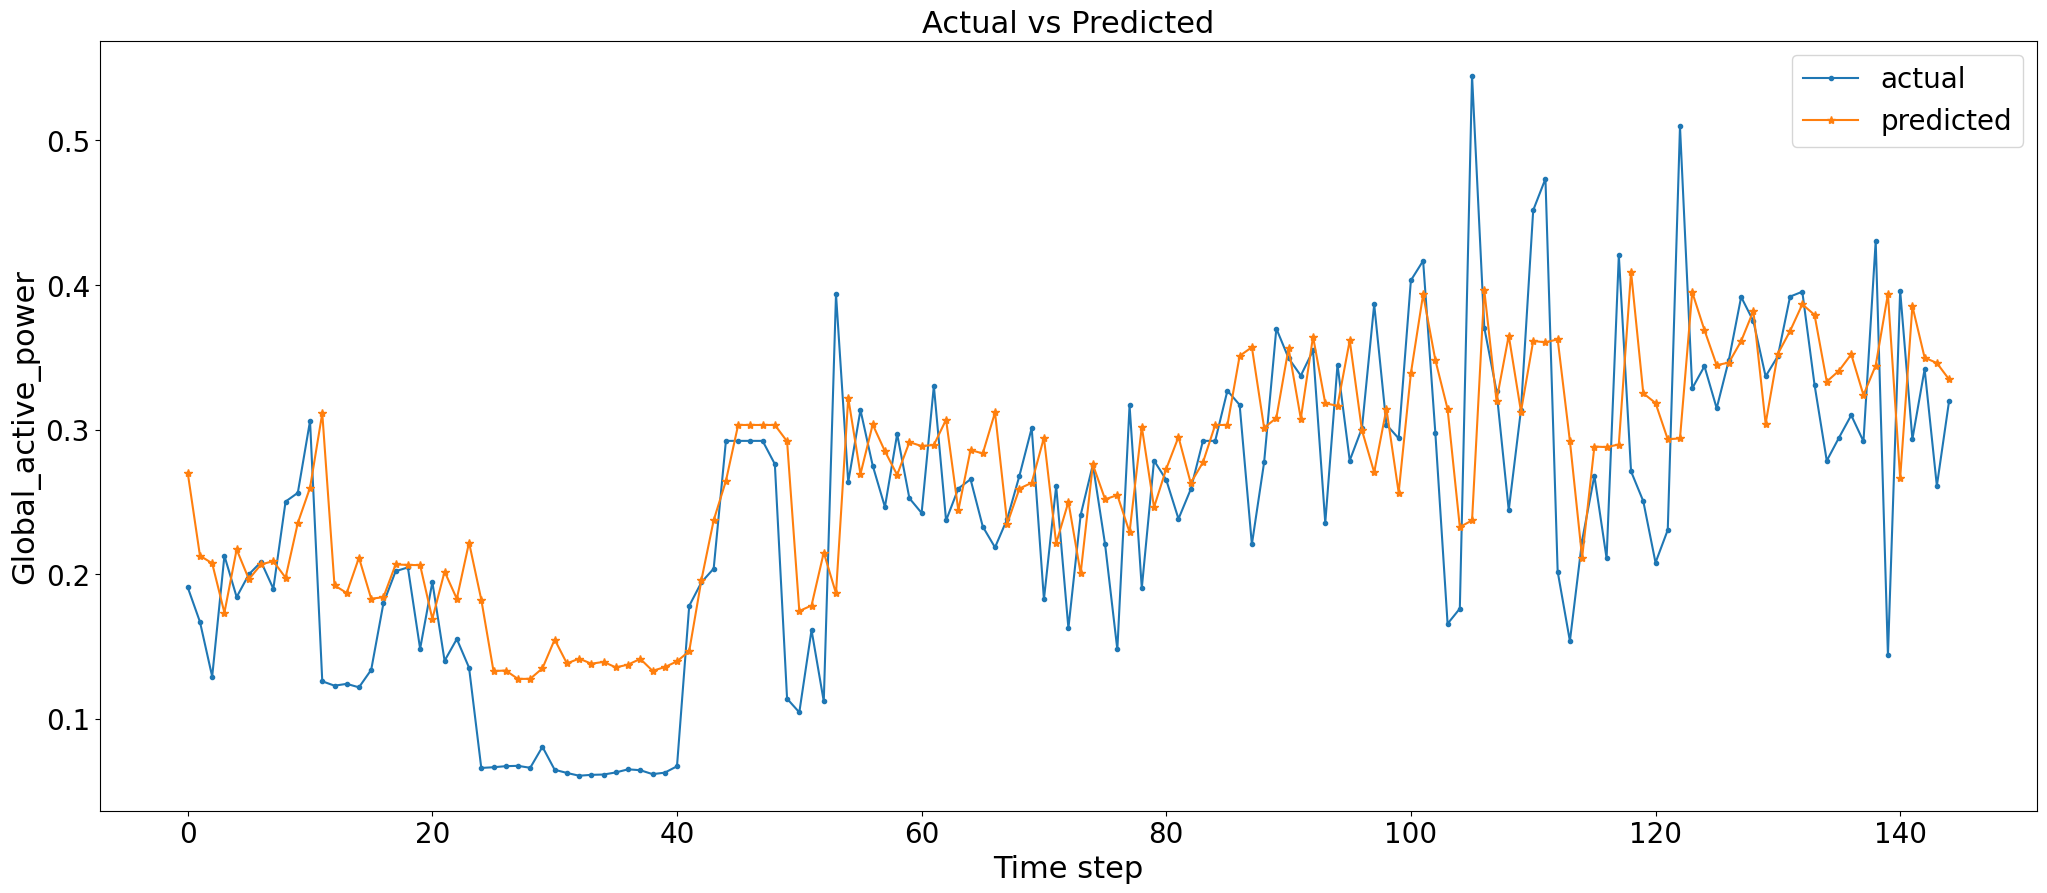

In [ ]:
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Predicted", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="predicted")
plt.legend(fontsize=20)
plt.show()

fgsm attack

In [ ]:
def fgsm_attack(model, epsilon, data, label):
  data = tf.convert_to_tensor(data)
  with tf.GradientTape() as tape:
    tape.watch(data)
    predictions = model(data)
    # print("Predictions", predictions)
    loss = tf.keras.losses.MSE(label, predictions)
  gradient = tape.gradient(loss, data)
  # print(gradient.shape)
  advX = data + (epsilon * np.sign(gradient))
  return advX

In [ ]:
advX = fgsm_attack(model, 0.05, test_X, test_y)
attack_loss = model.evaluate(advX, test_y)
print(f"Attack Loss: {attack_loss[0]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 - mae: 0.1265 
Attack Loss: 0.0188


In [ ]:
test_pred_advy = model.predict(advX)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


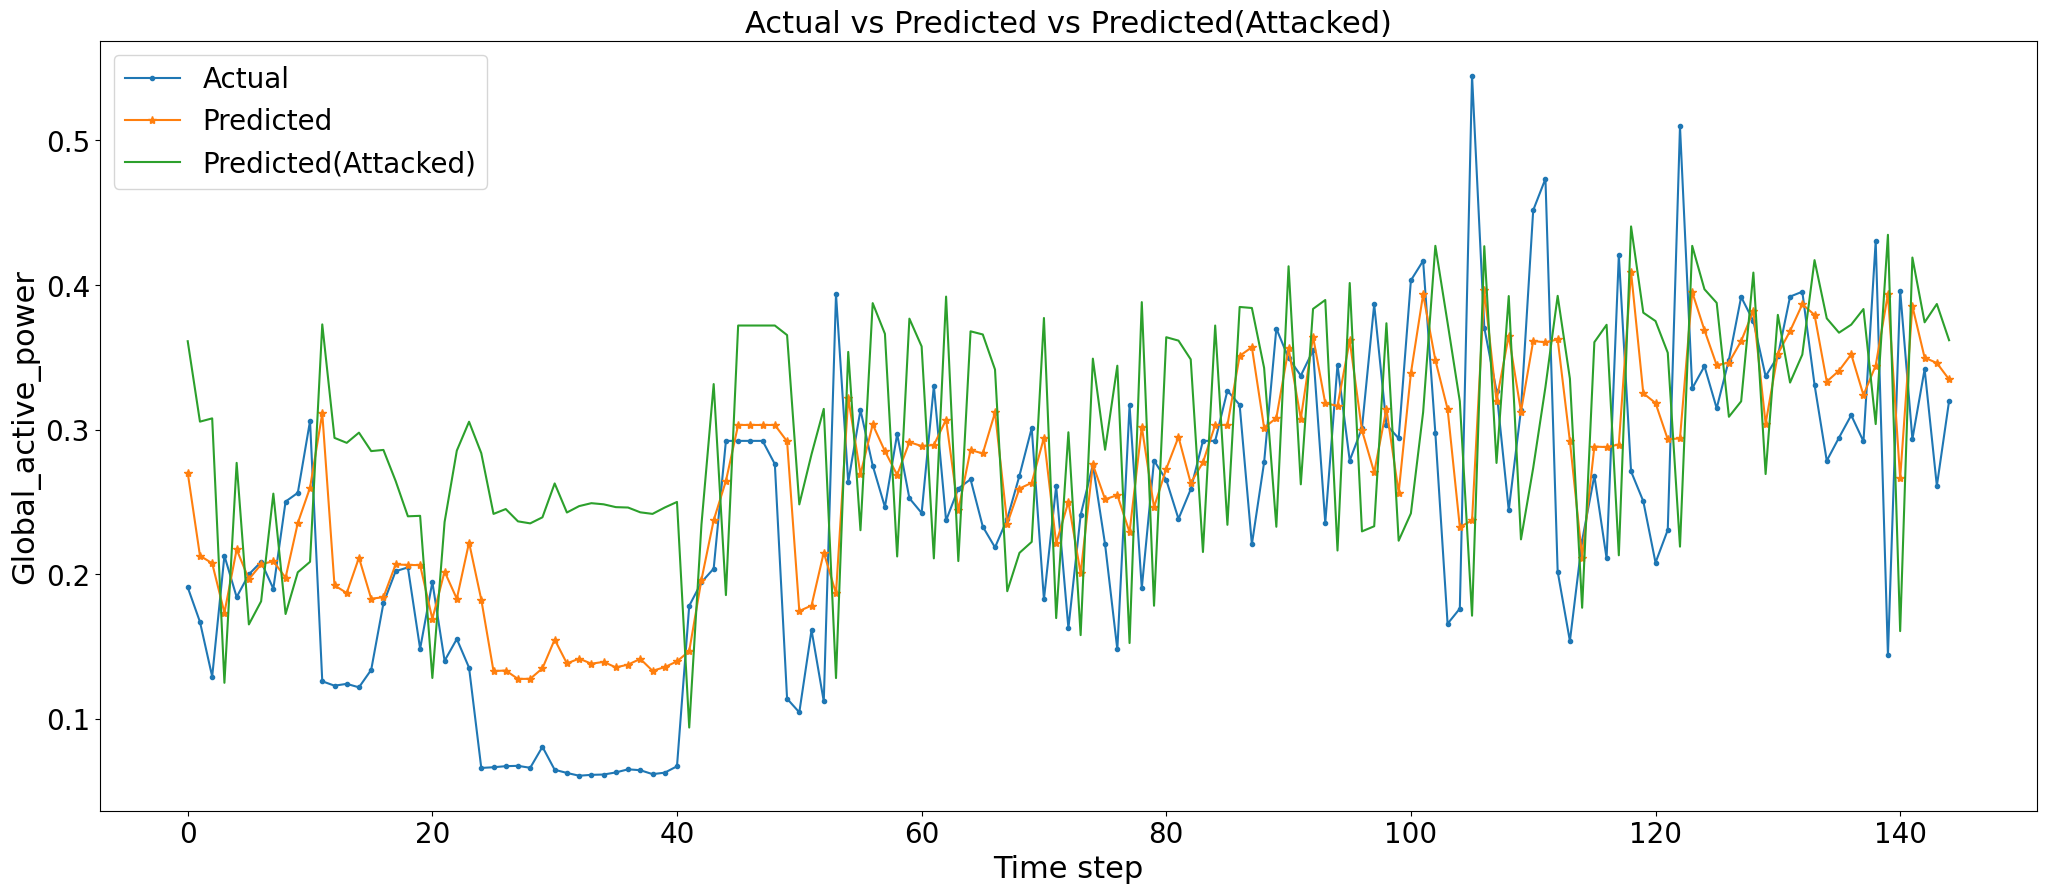

In [ ]:
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Predicted vs Predicted(Attacked)", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Predicted")
plt.plot(range(len(test_pred_advy)), test_pred_advy[:], label="Predicted(Attacked)")
plt.legend(fontsize=20)
plt.show()

adversarial defense training

In [ ]:
def adversarial_train(model, X_train, y_train, X_val, y_val, epsilon, epochs=50, batch_size=32):
  for epoch in range(epochs):
    advX_train = fgsm_attack(model, epsilon, X_train, y_train)

    combined_X = tf.concat([X_train, advX_train], axis=0)
    combined_y = tf.concat([y_train, y_train], axis=0)

    history = model.fit(
        combined_X, combined_y,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=batch_size,
        verbose=0
    )

    if epoch % 10 == 0:
      print(f'Epoch {epoch}/{epochs}, Loss: {history.history["loss"][0]:.4f}, Val Loss: {history.history["val_loss"][0]:.4f}')

  return model

In [ ]:
robust_model = adversarial_train(model, train_X, train_y, val_X, val_y, epsilon=0.05)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1036, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 0/50, Loss: 0.0159, Val Loss: 0.0071
Epoch 10/50, Loss: 0.0153, Val Loss: 0.0072
Epoch 20/50, Loss: 0.0152, Val Loss: 0.0073
Epoch 30/50, Loss: 0.0150, Val Loss: 0.0071
Epoch 40/50, Loss: 0.0148, Val Loss: 0.0077


In [ ]:
robust_test_loss = robust_model.evaluate(test_X, test_y)
print(f"Robust Model Test Loss: {robust_test_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - mae: 0.0591 
Robust Model Test Loss: 0.0064


In [ ]:
robust_attack_loss = robust_model.evaluate(advX, test_y)
print(f"Robust Model Attack Loss: {robust_attack_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - mae: 0.1003 
Robust Model Attack Loss: 0.0130


In [ ]:
robust_pred_y_test = robust_model.predict(test_X)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
robust_test_pred_advy = robust_model.predict(advX)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
import os
import tensorflow as tf

# Quantize the FGSM-robust model (using int8 quantization)
fgsm_robust_quantized_path = convert_to_tflite(
    robust_model,  # FGSM-robust model after adversarial training
    quantized_model_folder,
    model_name="int8_quantized_fgsm_robust_model.tflite"  # Updated to reflect int8 quantization
)

# Save the FGSM-robust model to a separate folder for unquantized models
unquantized_model_folder = "/content/drive/MyDrive/PES/unquantized_models"
os.makedirs(unquantized_model_folder, exist_ok=True)  # Ensure the folder exists

# Save the unquantized FGSM-robust model
fgsm_robust_model_path = os.path.join(unquantized_model_folder, "fgsm_robust_model.keras")
robust_model.save(fgsm_robust_model_path)

# Print paths for reference
print(f"FGSM-Robust Int8 Quantized Model saved at: {fgsm_robust_quantized_path}")
print(f"Unquantized FGSM-Robust Model saved at: {fgsm_robust_model_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Saved artifact at '/tmp/tmplgei9m3u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137169797688464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797689616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797686736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797686352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797690000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797689424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797690576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797690960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797691728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797689808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169797692688: Tens

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model saved at: /content/drive/MyDrive/PES/quantized_models/int8_quantized_fgsm_robust_model.tflite
FGSM-Robust Int8 Quantized Model saved at: /content/drive/MyDrive/PES/quantized_models/int8_quantized_fgsm_robust_model.tflite
Unquantized FGSM-Robust Model saved at: /content/drive/MyDrive/PES/unquantized_models/fgsm_robust_model.keras


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


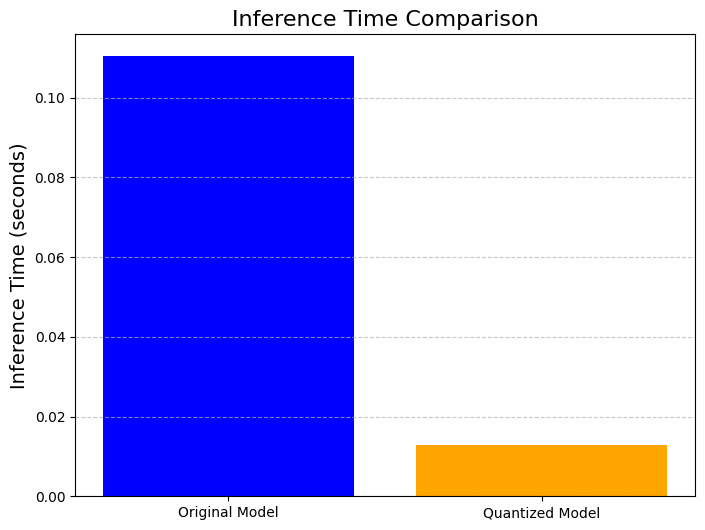

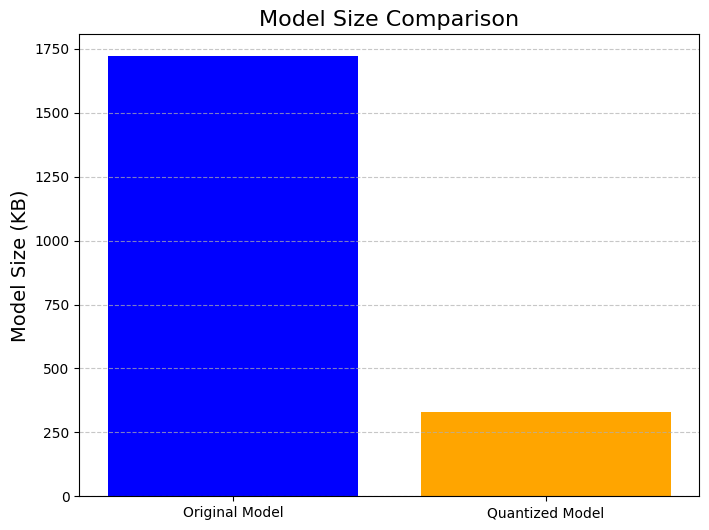

Transformer Model Inference Time (Original): 0.1103 seconds
Transformer Model Inference Time (Quantized): 0.0128 seconds
Transformer Model Size (Original): 1720.89 KB
Transformer Model Size (Quantized): 330.48 KB


In [ ]:
# Measure inference time for the transformer model on the test data
time_original = measure_inference_time_original(model, test_X)
time_quantized = measure_inference_time_quantized(quantized_model_path, test_X)

# Get model sizes
original_size = get_model_size(original_model_path)
quantized_size = get_model_size(quantized_model_path)

# Plot inference time comparison for the transformer model
plot_inference_time(time_original, time_quantized)

# Plot model size comparison for the transformer model
plot_model_size(original_size, quantized_size)

# Print results for the transformer model
print(f"Transformer Model Inference Time (Original): {time_original:.4f} seconds")
print(f"Transformer Model Inference Time (Quantized): {time_quantized:.4f} seconds")
print(f"Transformer Model Size (Original): {original_size:.2f} KB")
print(f"Transformer Model Size (Quantized): {quantized_size:.2f} KB")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


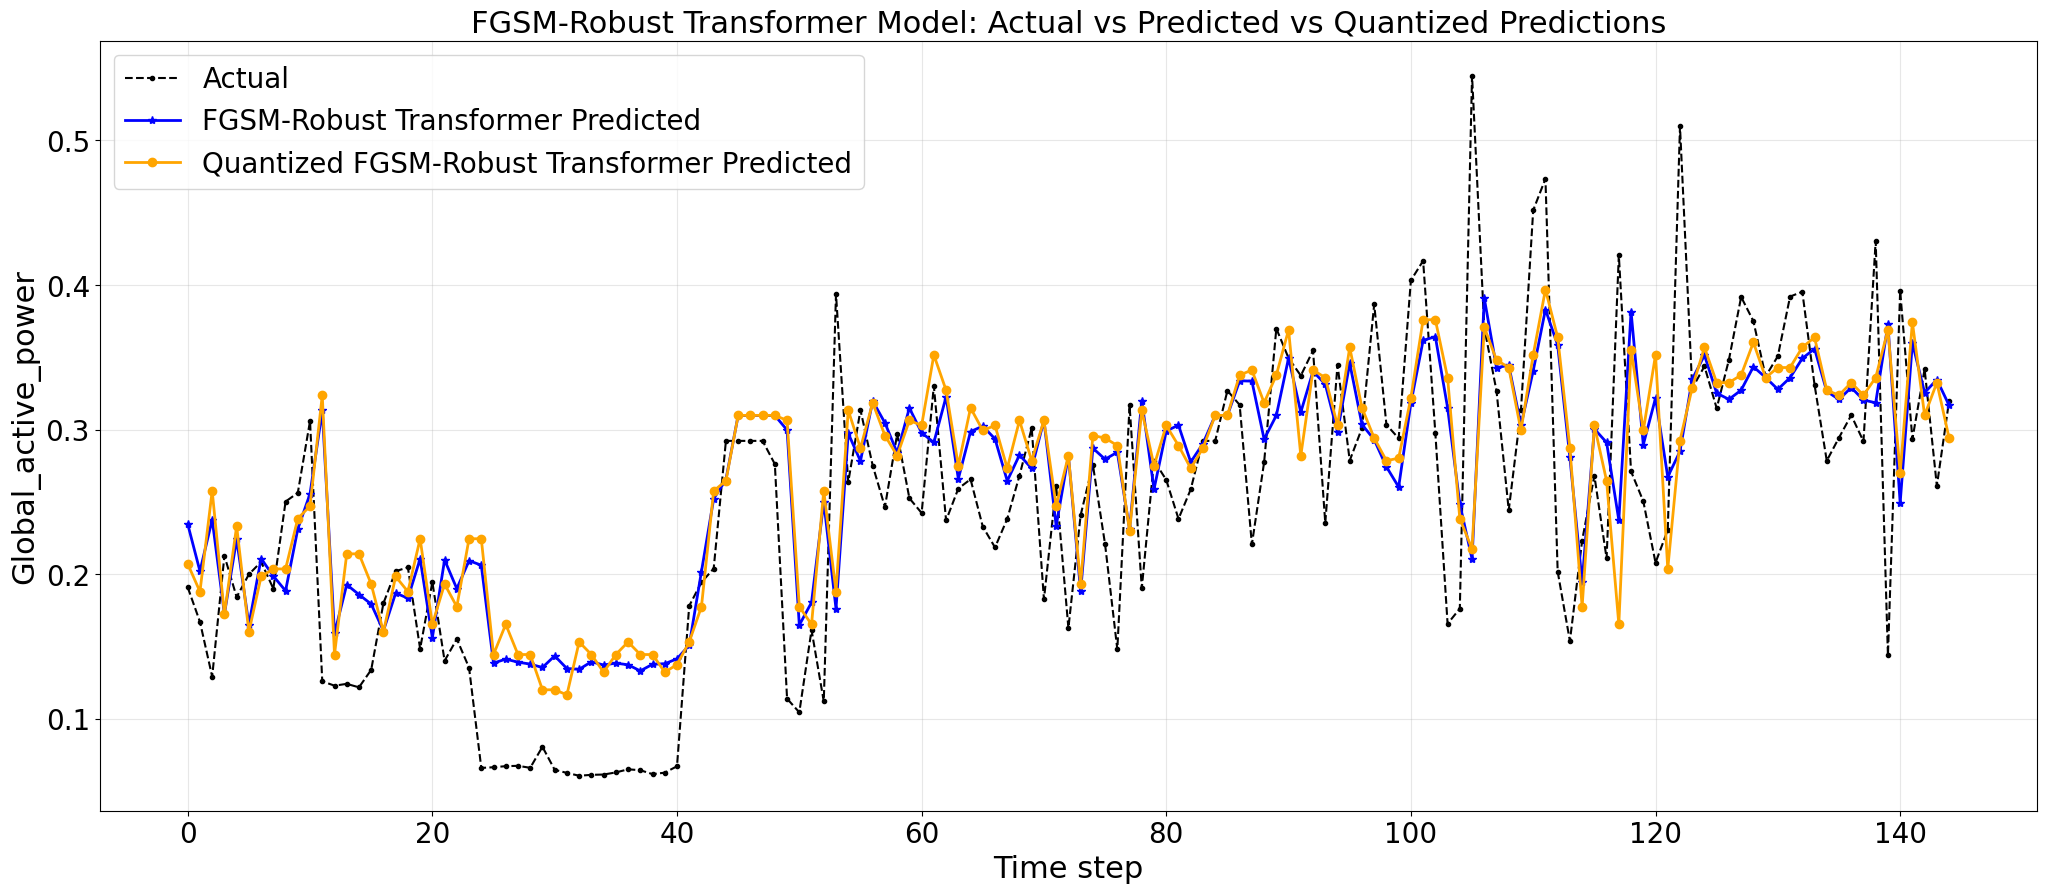

Actual Values (first 5): [0.19095185 0.16706197 0.12922366 0.21276482 0.18420601]
FGSM-Robust Transformer Predictions (first 5): [0.23462863 0.20209265 0.23774907 0.17253493 0.22415578]
Quantized FGSM-Robust Transformer Predictions (first 5): [0.2071321  0.18798544 0.25760968 0.17231999 0.23324119]
FGSM-Robust Transformer Prediction Differences (first 5): [ 0.02749653  0.01410721 -0.01986061  0.00021494 -0.00908541]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions for the FGSM-robust transformer model
robust_pred_y_test = robust_model.predict(test_X).flatten()  # Flatten to match test_y
quantized_robust_predictions = load_and_predict_tflite_model(fgsm_robust_quantized_path, test_X).flatten()  # Flatten for consistency

# Plot predictions for FGSM-robust transformer model (original vs quantized)
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("FGSM-Robust Transformer Model: Actual vs Predicted vs Quantized Predictions", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot actual values
plt.plot(range(len(test_y)), test_y, marker=".", label="Actual", color="black", linestyle="--", linewidth=1.5)

# Plot FGSM-robust transformer model predictions
plt.plot(range(len(robust_pred_y_test)), robust_pred_y_test, marker="*", label="FGSM-Robust Transformer Predicted", color="blue", linewidth=2)

# Plot quantized FGSM-robust transformer model predictions
plt.plot(range(len(quantized_robust_predictions)), quantized_robust_predictions, marker="o", label="Quantized FGSM-Robust Transformer Predicted", color="orange", linewidth=2)

# Add legend and show the plot
plt.legend(fontsize=20)
plt.grid(alpha=0.3)
plt.show()

# Print first few actual values, FGSM-robust predictions, and quantized FGSM-robust predictions
print("Actual Values (first 5):", test_y[:5])
print("FGSM-Robust Transformer Predictions (first 5):", robust_pred_y_test[:5])
print("Quantized FGSM-Robust Transformer Predictions (first 5):", quantized_robust_predictions[:5])

# Check for differences between FGSM-robust and quantized FGSM-robust predictions
robust_diff = robust_pred_y_test - quantized_robust_predictions
print("FGSM-Robust Transformer Prediction Differences (first 5):", robust_diff[:5])

# Calculate the absolute differences
robust_diff_abs = np.abs(robust_diff)

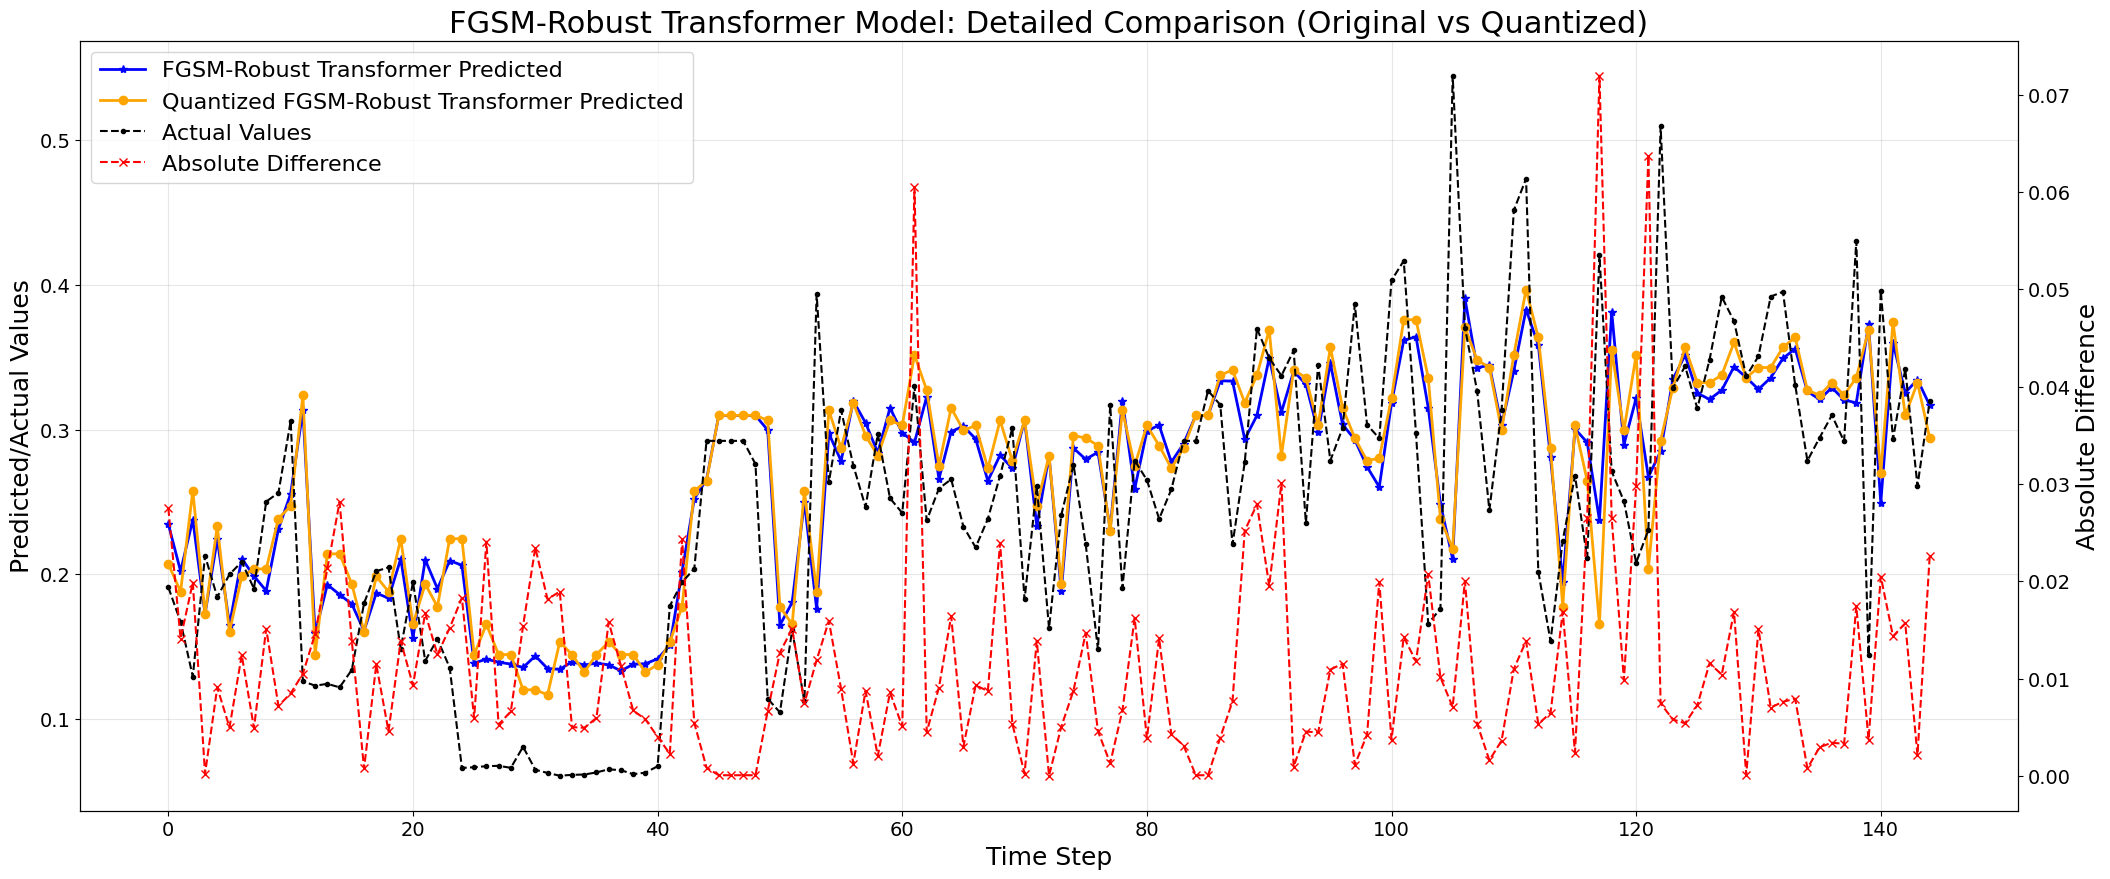

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a secondary y-axis for the differences
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot the FGSM-robust transformer model predictions
ax1.plot(range(len(robust_pred_y_test)), robust_pred_y_test,
         marker="*", label="FGSM-Robust Transformer Predicted",
         color="blue", linewidth=2)

# Plot the quantized FGSM-robust transformer model predictions
ax1.plot(range(len(quantized_robust_predictions)), quantized_robust_predictions,
         marker="o", label="Quantized FGSM-Robust Transformer Predicted",
         color="orange", linewidth=2)

# Plot actual values
ax1.plot(range(len(test_y)), test_y,
         marker=".", label="Actual Values",
         color="black", linestyle="--", linewidth=1.5)

# Label the primary y-axis
ax1.set_ylabel('Predicted/Actual Values', fontsize=18)
ax1.set_xlabel('Time Step', fontsize=18)

# Add a secondary y-axis for the differences
ax2 = ax1.twinx()
ax2.plot(range(len(robust_diff_abs)), robust_diff_abs,
         marker="x", label="Absolute Difference",
         color="red", linestyle="--", linewidth=1.5)
ax2.set_ylabel('Absolute Difference', fontsize=18)

# Add a title and grid
plt.title("FGSM-Robust Transformer Model: Detailed Comparison (Original vs Quantized)", fontsize=22)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc="upper left")

# Adjust tick sizes
ax1.tick_params(axis="both", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

# Show the plot
plt.show()

In [ ]:
# Inspect the quantized FGSM-robust transformer model
interpreter = tf.lite.Interpreter(model_path=fgsm_robust_quantized_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input details
print("Input Details [FGSM-Robust Transformer Model]:")
for idx, detail in enumerate(input_details):
    print(f"  Input Tensor {idx + 1}:")
    print(f"    Name: {detail['name']}")
    print(f"    Shape: {detail['shape']}")
    print(f"    Data Type: {detail['dtype']}")
    print(f"    Quantization (Scale, Zero Point): {detail['quantization']}")
    print("-" * 50)

# Print output details
print("Output Details [FGSM-Robust Transformer Model]:")
for idx, detail in enumerate(output_details):
    print(f"  Output Tensor {idx + 1}:")
    print(f"    Name: {detail['name']}")
    print(f"    Shape: {detail['shape']}")
    print(f"    Data Type: {detail['dtype']}")
    print(f"    Quantization (Scale, Zero Point): {detail['quantization']}")
    print("-" * 50)

Input Details [FGSM-Robust Transformer Model]:
  Input Tensor 1:
    Name: serving_default_keras_tensor:0
    Shape: [1 1 7]
    Data Type: <class 'numpy.uint8'>
    Quantization (Scale, Zero Point): (0.003921568859368563, 0)
--------------------------------------------------
Output Details [FGSM-Robust Transformer Model]:
  Output Tensor 1:
    Name: StatefulPartitionedCall_1:0
    Shape: [1 1]
    Data Type: <class 'numpy.uint8'>
    Quantization (Scale, Zero Point): (0.0017406059196218848, 0)
--------------------------------------------------


we can use this graph instead of having separate graphs for MAE, MSE, RMSE

Transformer Model MAE (Original): 0.060917885690
Transformer Model MAE (Quantized): 0.062031068681
Transformer Model RMSE (Original): 0.080271679752
Transformer Model RMSE (Quantized): 0.082573434553
Transformer Model MSE (Original): 0.006443542570
Transformer Model MSE (Quantized): 0.006818372094


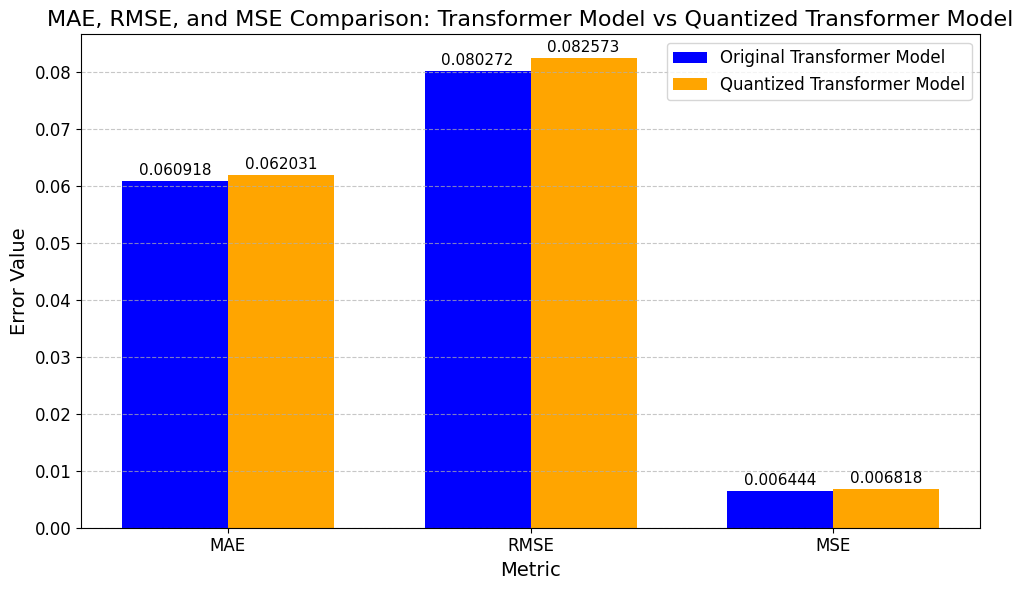

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate MAE, RMSE, and MSE for the FGSM-robust transformer model
mae_original = mean_absolute_error(test_y, robust_pred_y_test.flatten())
mae_quantized = mean_absolute_error(test_y, quantized_robust_predictions.flatten())

rmse_original = np.sqrt(mean_squared_error(test_y, robust_pred_y_test.flatten()))
rmse_quantized = np.sqrt(mean_squared_error(test_y, quantized_robust_predictions.flatten()))

mse_original = mean_squared_error(test_y, robust_pred_y_test.flatten())
mse_quantized = mean_squared_error(test_y, quantized_robust_predictions.flatten())

# Print the MAE, RMSE, and MSE values with high precision for the console (10+ decimal places)
print(f"Transformer Model MAE (Original): {mae_original:.12f}")
print(f"Transformer Model MAE (Quantized): {mae_quantized:.12f}")
print(f"Transformer Model RMSE (Original): {rmse_original:.12f}")
print(f"Transformer Model RMSE (Quantized): {rmse_quantized:.12f}")
print(f"Transformer Model MSE (Original): {mse_original:.12f}")
print(f"Transformer Model MSE (Quantized): {mse_quantized:.12f}")

# Data for the bar graph
metrics = ['MAE', 'RMSE', 'MSE']
original_values = [mae_original, rmse_original, mse_original]
quantized_values = [mae_quantized, rmse_quantized, mse_quantized]

# Create a grouped bar graph for MAE, RMSE, and MSE
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_values, width, label='Original Transformer Model', color='blue')
bars2 = ax.bar(x + width/2, quantized_values, width, label='Quantized Transformer Model', color='orange')

# Add labels and title
ax.set_ylabel('Error Value', fontsize=14)
ax.set_xlabel('Metric', fontsize=14)
ax.set_title('MAE, RMSE, and MSE Comparison: Transformer Model vs Quantized Transformer Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Add gridlines for better visualization
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars (6 decimal places for precision)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f"{height:.6f}", ha='center', fontsize=11)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

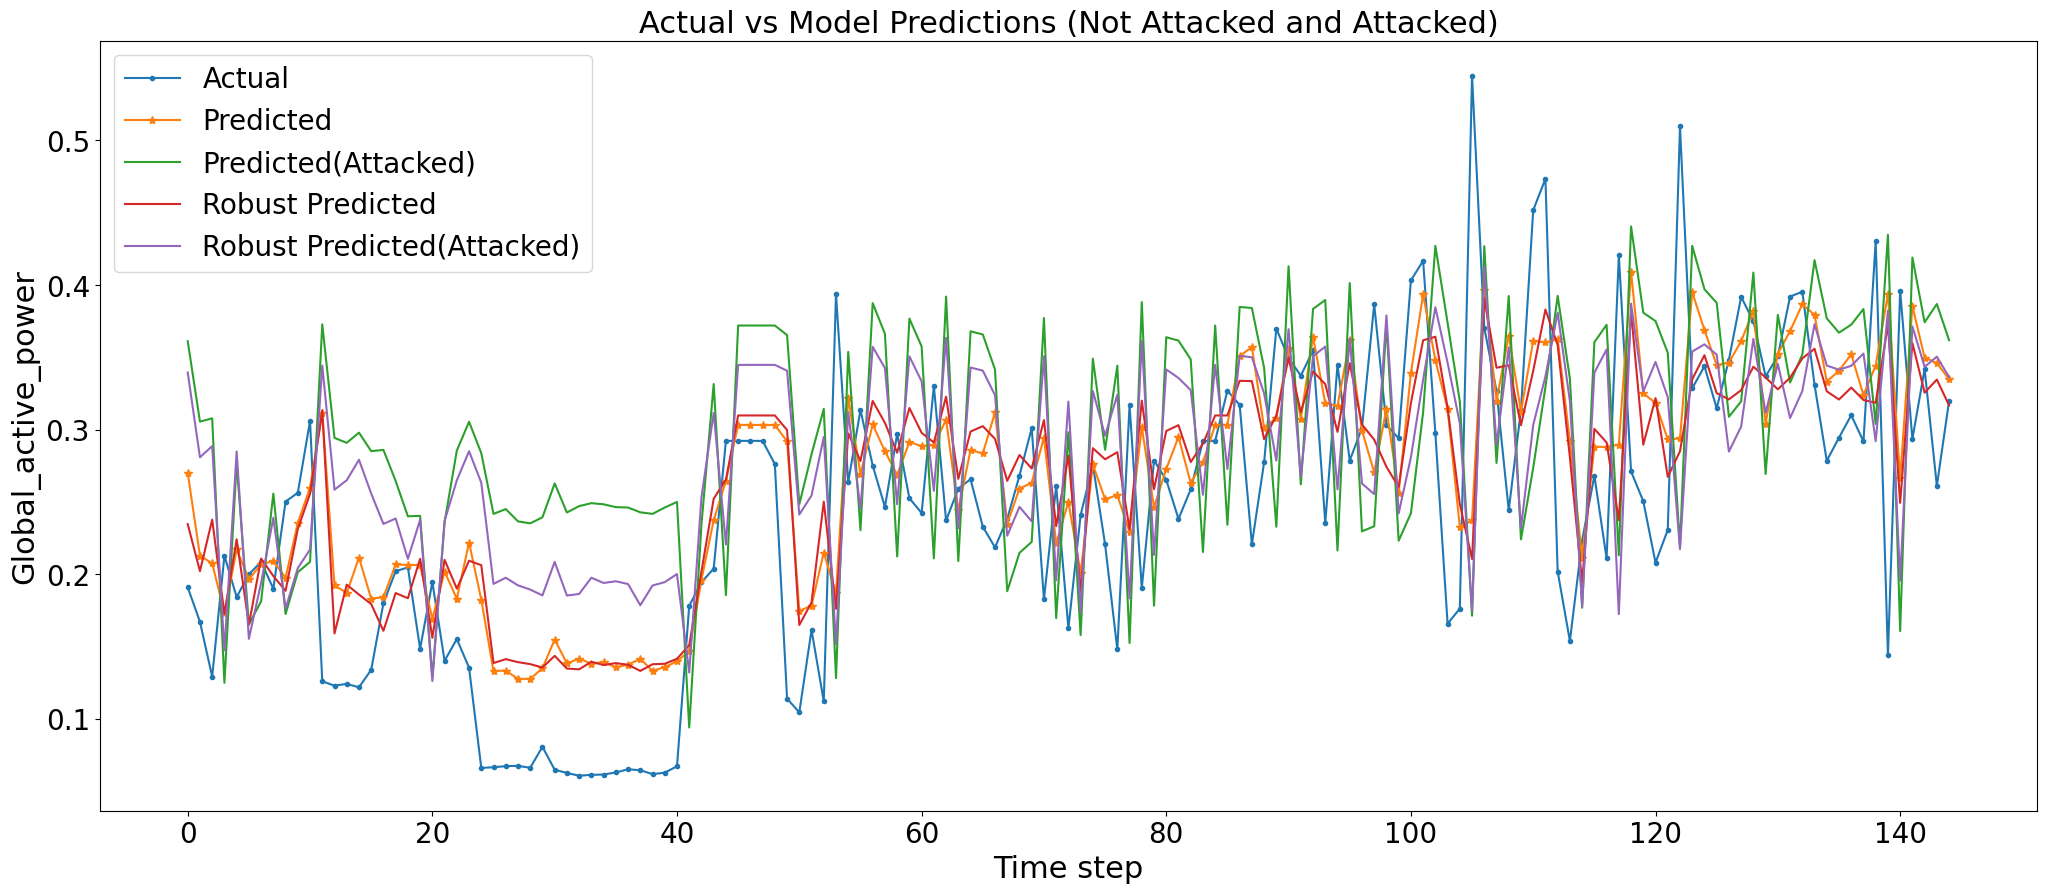

In [ ]:
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Model Predictions (Not Attacked and Attacked)", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Predicted")
plt.plot(range(len(test_pred_advy)), test_pred_advy[:], label="Predicted(Attacked)")
plt.plot(range(len(robust_pred_y_test)), robust_pred_y_test[:], label="Robust Predicted")
plt.plot(range(len(robust_test_pred_advy)), robust_test_pred_advy[:], label="Robust Predicted(Attacked)")
plt.legend(fontsize=20)
plt.show()

# BIM (Basic Iterative Method) attack

In [ ]:
def bim_attack(model, x, y, epsilon=0.05, alpha=0.01, iterations=10):
    """
    Implements the Basic Iterative Method attack.

    Args:
        model: The model to attack
        x: Original input
        y: Target output
        epsilon: Maximum perturbation
        alpha: Step size for each iteration
        iterations: Number of iterations

    Returns:
        Adversarial examples
    """
    advX = tf.identity(x)  # Create a copy of the input

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(advX)
            predictions = model(advX)
            loss = tf.keras.losses.MSE(y, predictions)

        # Get the gradients
        gradients = tape.gradient(loss, advX)

        # Create perturbation using sign of gradients (like FGSM)
        signed_grad = tf.sign(gradients)

        # Apply small perturbation in the direction of the gradient
        advX = advX + alpha * signed_grad

        # Project back to epsilon-ball around original x
        advX = tf.clip_by_value(advX, x - epsilon, x + epsilon)

        # Make sure we're still in valid input range [0,1]
        advX = tf.clip_by_value(advX, 0, 1)

    return advX

In [ ]:
# Generate BIM adversarial examples
print("Generating BIM adversarial examples...")
advX_bim = bim_attack(model, test_X, test_y, epsilon=0.1, alpha=0.01, iterations=10)

Generating BIM adversarial examples...


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
# Evaluate the standard model on BIM adversarial examples
bim_attack_loss = model.evaluate(advX_bim, test_y)
print(f"Standard Model BIM Attack Loss: {bim_attack_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0238 - mae: 0.1437 
Standard Model BIM Attack Loss: 0.0231


In [ ]:
# Generate predictions for visualization
bim_test_pred_advy = model.predict(advX_bim)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
# Train a model robust to BIM attacks using adversarial training
print("Training a model robust to BIM attacks...")
robust_bim_model = build_model(
  input_shape=(1,7),
  head_size=256,
  num_heads=4,
  ff_dim=4,
  num_transformer_blocks=4,
  mlp_units=[128],
  mlp_dropout=0.4,
  dropout=0.25
)
robust_bim_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

Training a model robust to BIM attacks...


In [ ]:
# Create adversarial examples for training
train_advX_bim = bim_attack(robust_bim_model, train_X, train_y,
                           epsilon=0.05, alpha=0.01, iterations=5)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1036, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
# Combine clean and adversarial examples for robust training
combined_X = tf.concat([train_X, train_advX_bim], axis=0)
combined_y = tf.concat([train_y, train_y], axis=0)

In [ ]:
# Train the robust model
robust_bim_model.fit(
    combined_X, combined_y,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0528 - mae: 0.1855 - val_loss: 0.0082 - val_mae: 0.0739
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0212 - mae: 0.1116 - val_loss: 0.0065 - val_mae: 0.0652
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0177 - mae: 0.1011 - val_loss: 0.0050 - val_mae: 0.0577
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0161 - mae: 0.0961 - val_loss: 0.0053 - val_mae: 0.0594
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0153 - mae: 0.0936 - val_loss: 0.0054 - val_mae: 0.0583
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0144 - mae: 0.0918 - val_loss: 0.0051 - val_mae: 0.0576
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0141 - mae: 0.0907 - val_loss: 0.0053 - val_mae: 0.0580
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0133 - mae: 0.0875 - val_loss: 0.0054 - val_mae: 0.0576


In [ ]:
# Evaluate the robust model on clean test data
robust_bim_test_loss = robust_bim_model.evaluate(test_X, test_y)
print(f"Robust BIM Model Test Loss: {robust_bim_test_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0673 
Robust BIM Model Test Loss: 0.0074


In [ ]:
# Evaluate the robust model on BIM adversarial examples
robust_bim_attack_loss = robust_bim_model.evaluate(advX_bim, test_y)
print(f"Robust BIM Model Attack Loss: {robust_bim_attack_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0202 - mae: 0.1269
Robust BIM Model Attack Loss: 0.0197


In [ ]:
import os
import tensorflow as tf
import numpy as np

# Step 1: Define a Representative Dataset Generator
def representative_data_gen():
    """
    Generates representative data for calibration during int8 quantization.
    Ensures the input data is in FLOAT32 format as required by the TensorFlow Lite Converter.
    """
    for i in range(min(100, len(train_X))):  # Use the first 100 samples for calibration
        yield [train_X[i:i + 1].astype(np.float32)]  # Cast to FLOAT32

# Step 2: Perform Int8 Quantization for BIM-Robust Transformer Model
converter = tf.lite.TFLiteConverter.from_keras_model(robust_bim_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable default optimizations
converter.representative_dataset = representative_data_gen  # Provide representative data
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Use int8 quantization
converter.inference_input_type = tf.int8  # Quantized input type
converter.inference_output_type = tf.int8  # Quantized output type

# Convert the model
bim_robust_quantized_int8_model = converter.convert()

# Save the quantized model
quantized_model_folder = "/content/drive/MyDrive/PES/quantized_models"
os.makedirs(quantized_model_folder, exist_ok=True)
bim_robust_quantized_path = os.path.join(quantized_model_folder, "int8_quantized_bim_robust_model.tflite")
with open(bim_robust_quantized_path, "wb") as f:
    f.write(bim_robust_quantized_int8_model)

print(f"Quantized BIM-Robust Transformer Model saved to: {bim_robust_quantized_path}")


# Save the BIM-robust model to a separate folder for unquantized models
unquantized_model_folder = "/content/drive/MyDrive/PES/unquantized_models"
os.makedirs(unquantized_model_folder, exist_ok=True)  # Ensure the folder exists

# Save the unquantized BIM-robust model
bim_robust_model_path = os.path.join(unquantized_model_folder, "bim_robust_model.keras")
robust_bim_model.save(bim_robust_model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Saved artifact at '/tmp/tmpeagm4wvi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137169746205712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746203600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746213008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746198608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746208592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746198800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746214736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746207248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746212432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746208208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169746211664: Tens

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized BIM-Robust Transformer Model saved to: /content/drive/MyDrive/PES/quantized_models/int8_quantized_bim_robust_model.tflite


Expected Input Shape: [1 1 7]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
BIM-Robust Transformer Model Inference Time (Original): 0.1326 seconds
BIM-Robust Transformer Model Inference Time (Quantized): 0.0001 seconds
BIM-Robust Transformer Model Size (Original): 1720.89 KB
BIM-Robust Transformer Model Size (Quantized): 330.12 KB


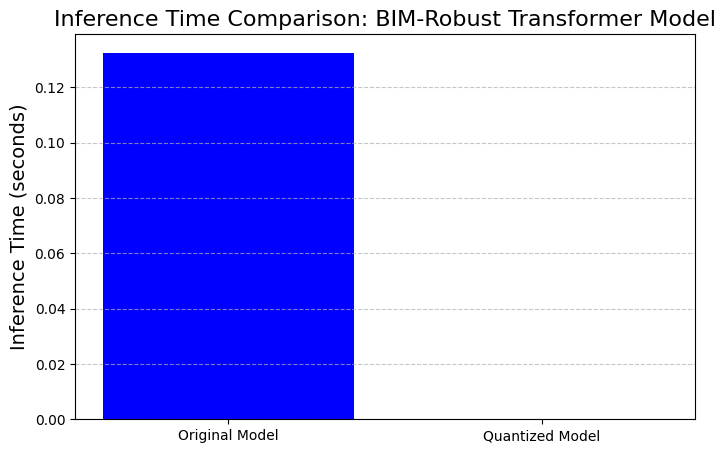

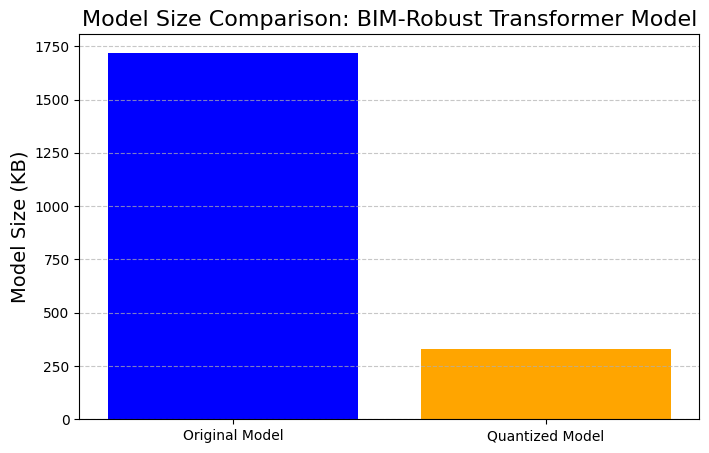

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocess the test data to match the quantized input requirements (INT8)
def preprocess_for_int8(input_data, scale, zero_point):
    """
    Preprocesses the input data to INT8 format with the correct scale and zero point.
    """
    input_data = input_data.astype(np.float32)  # Ensure data is float32
    input_data = (input_data / scale + zero_point).astype(np.int8)  # Scale and quantize
    return input_data

# Extract representative dataset samples and preprocess them to INT8
def extract_and_preprocess_samples(representative_data_gen, required_num_samples, scale, zero_point):
    """
    Extracts samples from the representative dataset generator and preprocesses them to INT8.
    """
    samples = []
    for i, sample in enumerate(representative_data_gen()):
        if i >= required_num_samples:
            break
        preprocessed_sample = preprocess_for_int8(sample[0], scale, zero_point)
        samples.append(preprocessed_sample)
    return np.array(samples)

# Load the TFLite interpreter and allocate tensors
interpreter = tf.lite.Interpreter(model_path=bim_robust_quantized_path)
interpreter.allocate_tensors()

# Get input tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_scale, input_zero_point = input_details[0]['quantization']

# Extract and preprocess representative dataset samples
test_X_int8 = extract_and_preprocess_samples(representative_data_gen, len(test_X), input_scale, input_zero_point)

# Fix the dimension mismatch
expected_shape = input_details[0]['shape']  # Expected input shape for the model
print("Expected Input Shape:", expected_shape)

# Reshape the data to match the model's input shape
test_X_int8 = test_X_int8.reshape((-1, *expected_shape[1:]))

# Measure inference time for the quantized model
def measure_inference_time_quantized(interpreter, input_data):
    """
    Measures inference time for a quantized TFLite model.
    """
    import time

    # Get input and output tensor indices
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    # Time the inference
    start_time = time.time()
    for i in range(len(input_data)):
        # Set input tensor
        interpreter.set_tensor(input_index, input_data[i:i+1])  # Batch size = 1
        interpreter.invoke()  # Run inference
    end_time = time.time()

    # Calculate total inference time
    total_time = end_time - start_time
    avg_time_per_sample = total_time / len(input_data)
    return avg_time_per_sample

# Measure inference time for both original and quantized models
bim_robust_time_original = measure_inference_time_original(robust_bim_model, test_X)
bim_robust_time_quantized = measure_inference_time_quantized(interpreter, test_X_int8)

# Get model sizes
bim_robust_original_size = get_model_size(bim_robust_model_path)
bim_robust_quantized_size = get_model_size(bim_robust_quantized_path)

# Print results for BIM-robust transformer model
print(f"BIM-Robust Transformer Model Inference Time (Original): {bim_robust_time_original:.4f} seconds")
print(f"BIM-Robust Transformer Model Inference Time (Quantized): {bim_robust_time_quantized:.4f} seconds")
print(f"BIM-Robust Transformer Model Size (Original): {bim_robust_original_size:.2f} KB")
print(f"BIM-Robust Transformer Model Size (Quantized): {bim_robust_quantized_size:.2f} KB")

# Plot inference time comparison
def plot_inference_time(original_time, quantized_time):
    """
    Plots a bar chart comparing inference time for original and quantized models.
    """
    models = ['Original Model', 'Quantized Model']
    times = [original_time, quantized_time]

    plt.figure(figsize=(8, 5))
    plt.bar(models, times, color=['blue', 'orange'])
    plt.ylabel('Inference Time (seconds)', fontsize=14)
    plt.title('Inference Time Comparison: BIM-Robust Transformer Model', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot model size comparison
def plot_model_size(original_size, quantized_size):
    """
    Plots a bar chart comparing model sizes for original and quantized models.
    """
    models = ['Original Model', 'Quantized Model']
    sizes = [original_size, quantized_size]

    plt.figure(figsize=(8, 5))
    plt.bar(models, sizes, color=['blue', 'orange'])
    plt.ylabel('Model Size (KB)', fontsize=14)
    plt.title('Model Size Comparison: BIM-Robust Transformer Model', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot inference time comparison
plot_inference_time(bim_robust_time_original, bim_robust_time_quantized)

# Plot model size comparison
plot_model_size(bim_robust_original_size, bim_robust_quantized_size)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


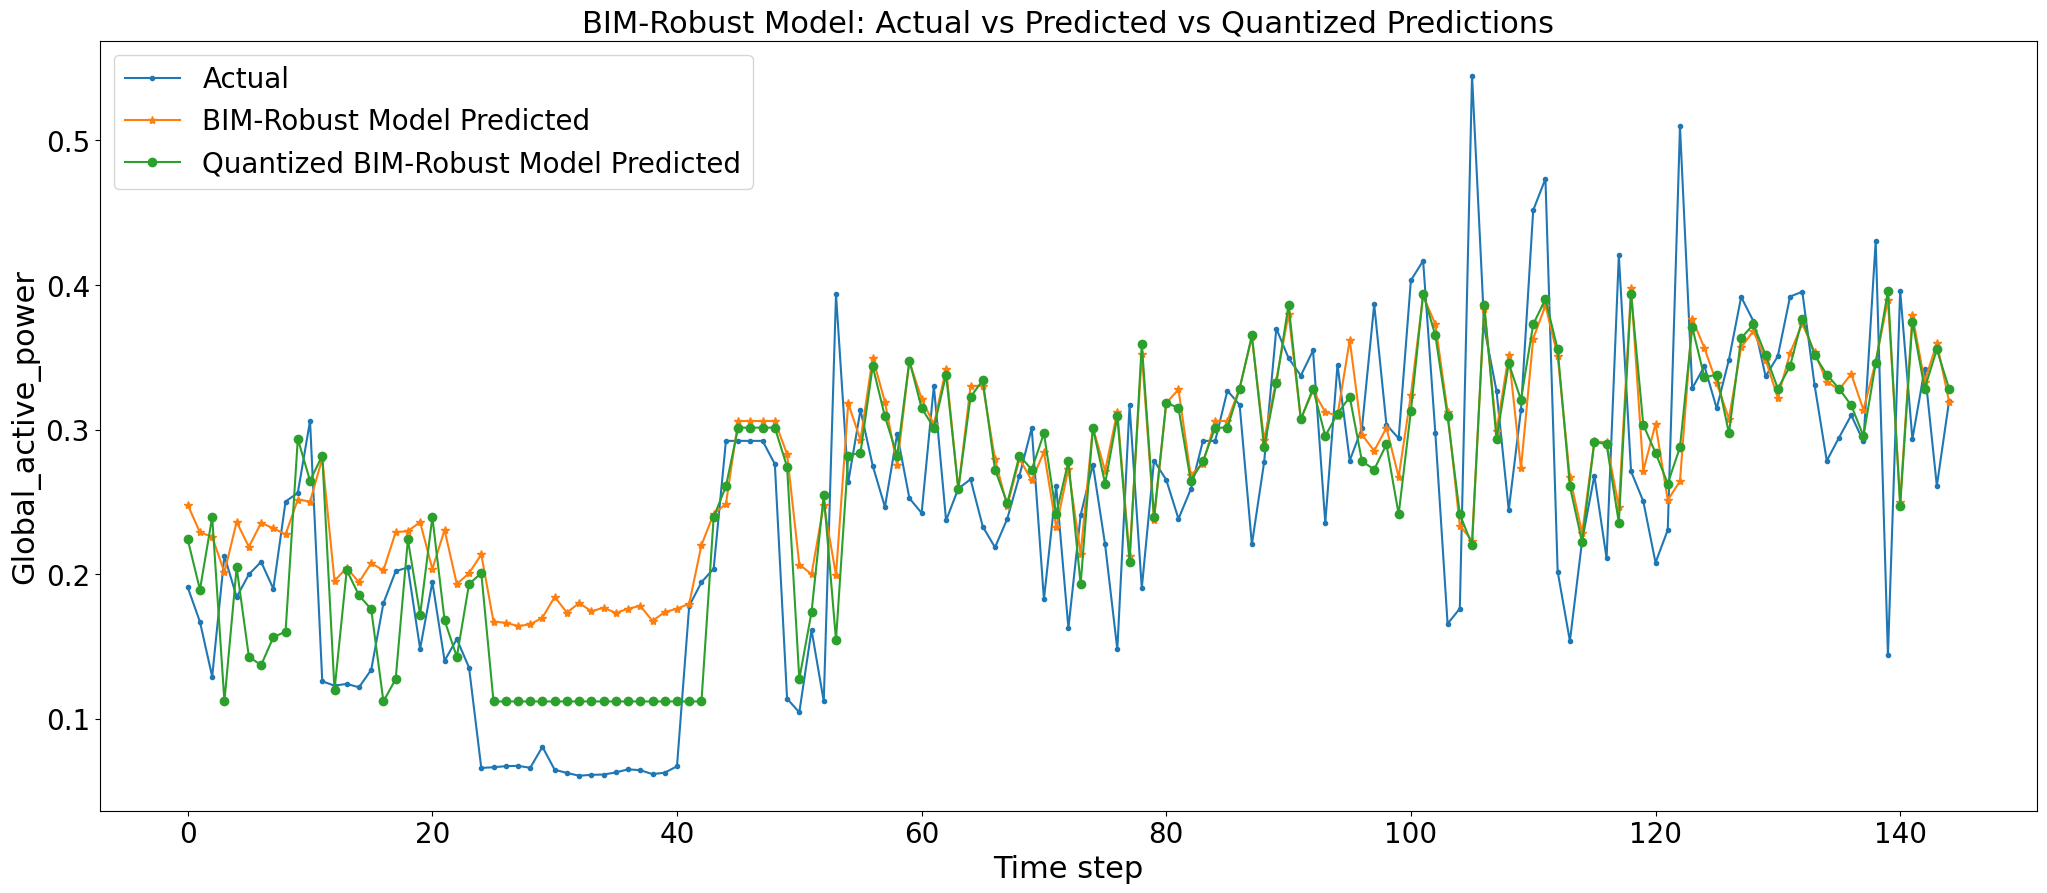

Actual Values (first 5): [0.19095185 0.16706197 0.12922366 0.21276482 0.18420601]
BIM-Robust Model Predictions (first 5): [[0.24796192]
 [0.22891758]
 [0.22593068]
 [0.20124684]
 [0.23618473]]
Quantized BIM-Robust Model Predictions (first 5): [0.22406669 0.18929772 0.23951957 0.11203334 0.2047506 ]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocess the test data to match the quantized model's input requirements
def preprocess_for_int8(input_data, scale, zero_point):
    """
    Preprocesses the input data to INT8 format with the correct scale and zero point.
    """
    input_data = input_data.astype(np.float32)  # Ensure data is float32
    input_data = (input_data / scale + zero_point).astype(np.int8)  # Scale and quantize
    return input_data

# Load and predict with the TFLite quantized BIM-robust model
def load_and_predict_tflite_model(tflite_model_path, input_data):
    """
    Loads a TFLite model and generates predictions on input data.
    """
    # Load the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Extract scale and zero point for input normalization
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    # Preprocess input data to match quantized model requirements
    input_data_int8 = preprocess_for_int8(input_data, input_scale, input_zero_point)

    # Post-process output to dequantize predictions
    def dequantize_output(output_data, scale, zero_point):
        return scale * (output_data.astype(np.float32) - zero_point)

    # Generate predictions
    predictions = []
    for i in range(len(input_data_int8)):
        interpreter.set_tensor(input_details[0]['index'], input_data_int8[i:i+1])  # Batch size = 1
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(dequantize_output(output_data, output_scale, output_zero_point))

    return np.array(predictions).squeeze()  # Remove unnecessary dimensions

# Generate predictions with the quantized BIM-robust model
quantized_bim_robust_predictions = load_and_predict_tflite_model(bim_robust_quantized_path, test_X)

# Generate predictions with the original BIM-robust model
bim_robust_pred_y_test = robust_bim_model.predict(test_X)

# Plot predictions for BIM-robust model (original vs quantized)
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("BIM-Robust Model: Actual vs Predicted vs Quantized Predictions", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot actual values
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")

# Plot BIM-robust model predictions
plt.plot(range(len(bim_robust_pred_y_test)), bim_robust_pred_y_test[:], marker="*", label="BIM-Robust Model Predicted")

# Plot quantized BIM-robust model predictions
plt.plot(range(len(quantized_bim_robust_predictions)), quantized_bim_robust_predictions[:], marker="o", label="Quantized BIM-Robust Model Predicted")

# Add legend and show the plot
plt.legend(fontsize=20)
plt.show()

# Print first few actual values, BIM-robust predictions, and quantized BIM-robust predictions
print("Actual Values (first 5):", test_y[:5])
print("BIM-Robust Model Predictions (first 5):", bim_robust_pred_y_test[:5])
print("Quantized BIM-Robust Model Predictions (first 5):", quantized_bim_robust_predictions[:5])

Aligned Shape of bim_robust_pred_y_test: (145,)
Aligned Shape of quantized_bim_robust_predictions: (145,)
BIM-Robust Absolute Differences (first 5): [0.02389523 0.03961986 0.01358889 0.0892135  0.03143413]


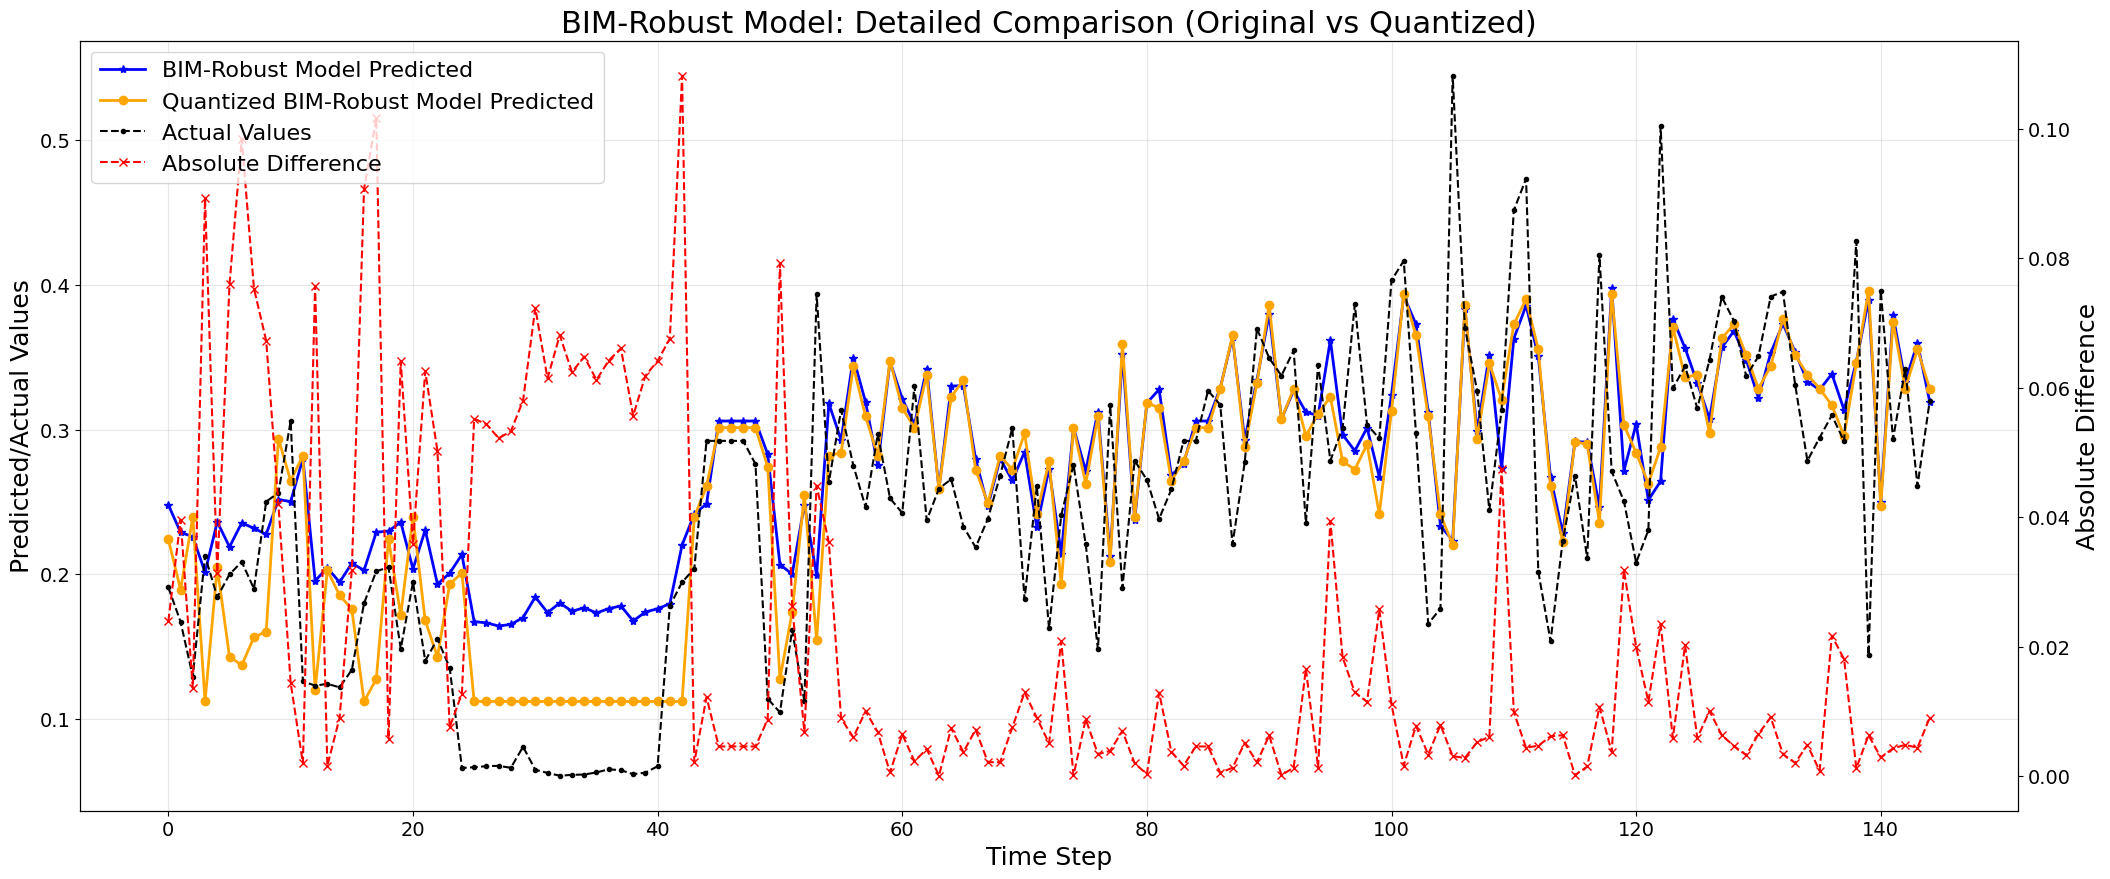

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten bim_robust_pred_y_test to ensure it is 1D
bim_robust_pred_y_test = bim_robust_pred_y_test.flatten()

# Debugging: Print shapes of predictions after alignment
print("Aligned Shape of bim_robust_pred_y_test:", bim_robust_pred_y_test.shape)
print("Aligned Shape of quantized_bim_robust_predictions:", quantized_bim_robust_predictions.shape)

# Calculate the absolute differences
bim_robust_diff_abs = np.abs(bim_robust_pred_y_test - quantized_bim_robust_predictions)

# Print the first 5 absolute differences for verification
print("BIM-Robust Absolute Differences (first 5):", bim_robust_diff_abs[:5])

# Create a figure with a secondary y-axis for the differences
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot the BIM-robust model predictions
ax1.plot(
    range(len(bim_robust_pred_y_test)),
    bim_robust_pred_y_test[:],
    marker="*",
    label="BIM-Robust Model Predicted",
    color="blue",
    linewidth=2
)

# Plot the quantized BIM-robust model predictions
ax1.plot(
    range(len(quantized_bim_robust_predictions)),
    quantized_bim_robust_predictions[:],
    marker="o",
    label="Quantized BIM-Robust Model Predicted",
    color="orange",
    linewidth=2
)

# Plot actual values
ax1.plot(
    range(len(test_y)),
    test_y[:],
    marker=".",
    label="Actual Values",
    color="black",
    linestyle="--",
    linewidth=1.5
)

# Label the primary y-axis
ax1.set_ylabel('Predicted/Actual Values', fontsize=18)
ax1.set_xlabel('Time Step', fontsize=18)

# Add a secondary y-axis for the absolute differences
ax2 = ax1.twinx()

# Plot the absolute differences as a single line
ax2.plot(
    range(len(bim_robust_diff_abs)),
    bim_robust_diff_abs,
    marker="x",
    label="Absolute Difference",
    color="red",
    linestyle="--",
    linewidth=1.5
)
ax2.set_ylabel('Absolute Difference', fontsize=18)

# Add a title and grid
plt.title("BIM-Robust Model: Detailed Comparison (Original vs Quantized)", fontsize=22)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc="upper left")

# Adjust tick sizes
ax1.tick_params(axis="both", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

# Show the plot
plt.show()

In [ ]:
# Inspect the quantized BIM-robust transformer model
interpreter = tf.lite.Interpreter(model_path=bim_robust_quantized_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input details
print("Input Details [BIM-Robust Transformer Model]:")
for idx, detail in enumerate(input_details):
    print(f"  Input Tensor {idx + 1}:")
    print(f"    Name: {detail['name']}")
    print(f"    Shape: {detail['shape']}")
    print(f"    Data Type: {detail['dtype']}")
    print(f"    Quantization (Scale, Zero Point): {detail['quantization']}")
    print("-" * 50)

# Print output details
print("Output Details [BIM-Robust Transformer Model]:")
for idx, detail in enumerate(output_details):
    print(f"  Output Tensor {idx + 1}:")
    print(f"    Name: {detail['name']}")
    print(f"    Shape: {detail['shape']}")
    print(f"    Data Type: {detail['dtype']}")
    print(f"    Quantization (Scale, Zero Point): {detail['quantization']}")
    print("-" * 50)

Input Details [BIM-Robust Transformer Model]:
  Input Tensor 1:
    Name: serving_default_keras_tensor:0
    Shape: [1 1 7]
    Data Type: <class 'numpy.int8'>
    Quantization (Scale, Zero Point): (0.003921568859368563, -128)
--------------------------------------------------
Output Details [BIM-Robust Transformer Model]:
  Output Tensor 1:
    Name: StatefulPartitionedCall_1:0
    Shape: [1 1]
    Data Type: <class 'numpy.int8'>
    Quantization (Scale, Zero Point): (0.0019316093530505896, -128)
--------------------------------------------------


BIM-Robust Model MAE (Original): 0.066533944659
BIM-Robust Model MAE (Quantized): 0.059283684268
BIM-Robust Model RMSE (Original): 0.085939316397
BIM-Robust Model RMSE (Quantized): 0.079749079285
BIM-Robust Model MSE (Original): 0.007385566103
BIM-Robust Model MSE (Quantized): 0.006359915647


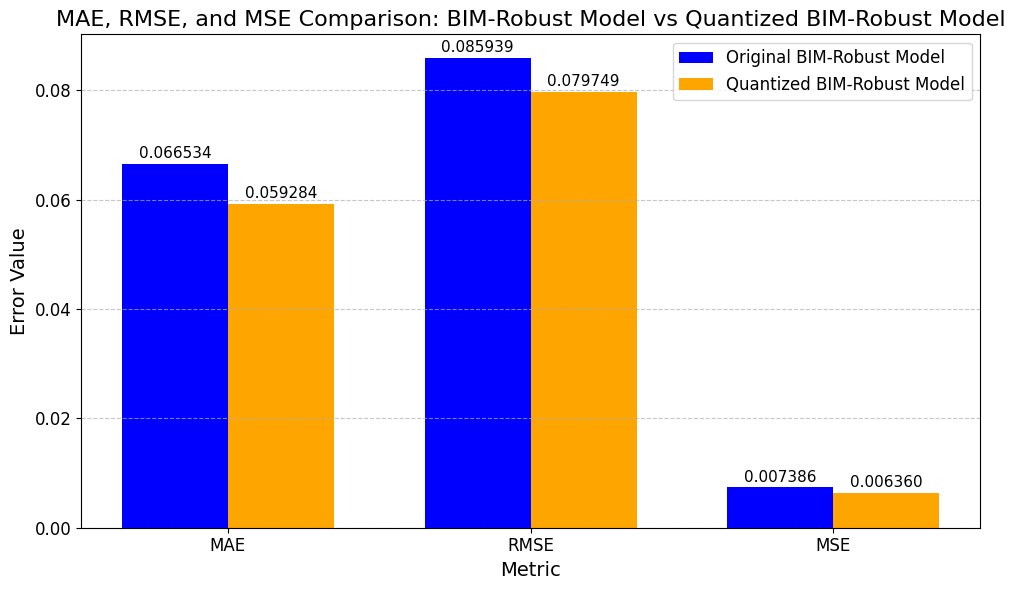

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Ensure the predictions are aligned with the actual values
assert len(test_y) == len(bim_robust_pred_y_test) == len(quantized_bim_robust_predictions), \
    "Mismatch in lengths of test_y, bim_robust_pred_y_test, and quantized_bim_robust_predictions!"

# Calculate MAE, RMSE, and MSE for BIM-robust model
bim_robust_mae_original = mean_absolute_error(test_y, bim_robust_pred_y_test)
bim_robust_mae_quantized = mean_absolute_error(test_y, quantized_bim_robust_predictions)

bim_robust_rmse_original = np.sqrt(mean_squared_error(test_y, bim_robust_pred_y_test))
bim_robust_rmse_quantized = np.sqrt(mean_squared_error(test_y, quantized_bim_robust_predictions))

bim_robust_mse_original = mean_squared_error(test_y, bim_robust_pred_y_test)
bim_robust_mse_quantized = mean_squared_error(test_y, quantized_bim_robust_predictions)

# Print the MAE, RMSE, and MSE values with high precision for the console (12 decimal places)
print(f"BIM-Robust Model MAE (Original): {bim_robust_mae_original:.12f}")
print(f"BIM-Robust Model MAE (Quantized): {bim_robust_mae_quantized:.12f}")
print(f"BIM-Robust Model RMSE (Original): {bim_robust_rmse_original:.12f}")
print(f"BIM-Robust Model RMSE (Quantized): {bim_robust_rmse_quantized:.12f}")
print(f"BIM-Robust Model MSE (Original): {bim_robust_mse_original:.12f}")
print(f"BIM-Robust Model MSE (Quantized): {bim_robust_mse_quantized:.12f}")

# Data for the bar graph
metrics = ['MAE', 'RMSE', 'MSE']
original_values = [bim_robust_mae_original, bim_robust_rmse_original, bim_robust_mse_original]
quantized_values = [bim_robust_mae_quantized, bim_robust_rmse_quantized, bim_robust_mse_quantized]

# Create a grouped bar graph for MAE, RMSE, and MSE
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_values, width, label='Original BIM-Robust Model', color='blue')
bars2 = ax.bar(x + width/2, quantized_values, width, label='Quantized BIM-Robust Model', color='orange')

# Add labels and title
ax.set_ylabel('Error Value', fontsize=14)
ax.set_xlabel('Metric', fontsize=14)
ax.set_title('MAE, RMSE, and MSE Comparison: BIM-Robust Model vs Quantized BIM-Robust Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Add gridlines for better visualization
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars (6 decimal places for precision)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f"{height:.6f}", ha='center', fontsize=11)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

NameError: name 'robust_bim_pred_y_test' is not defined

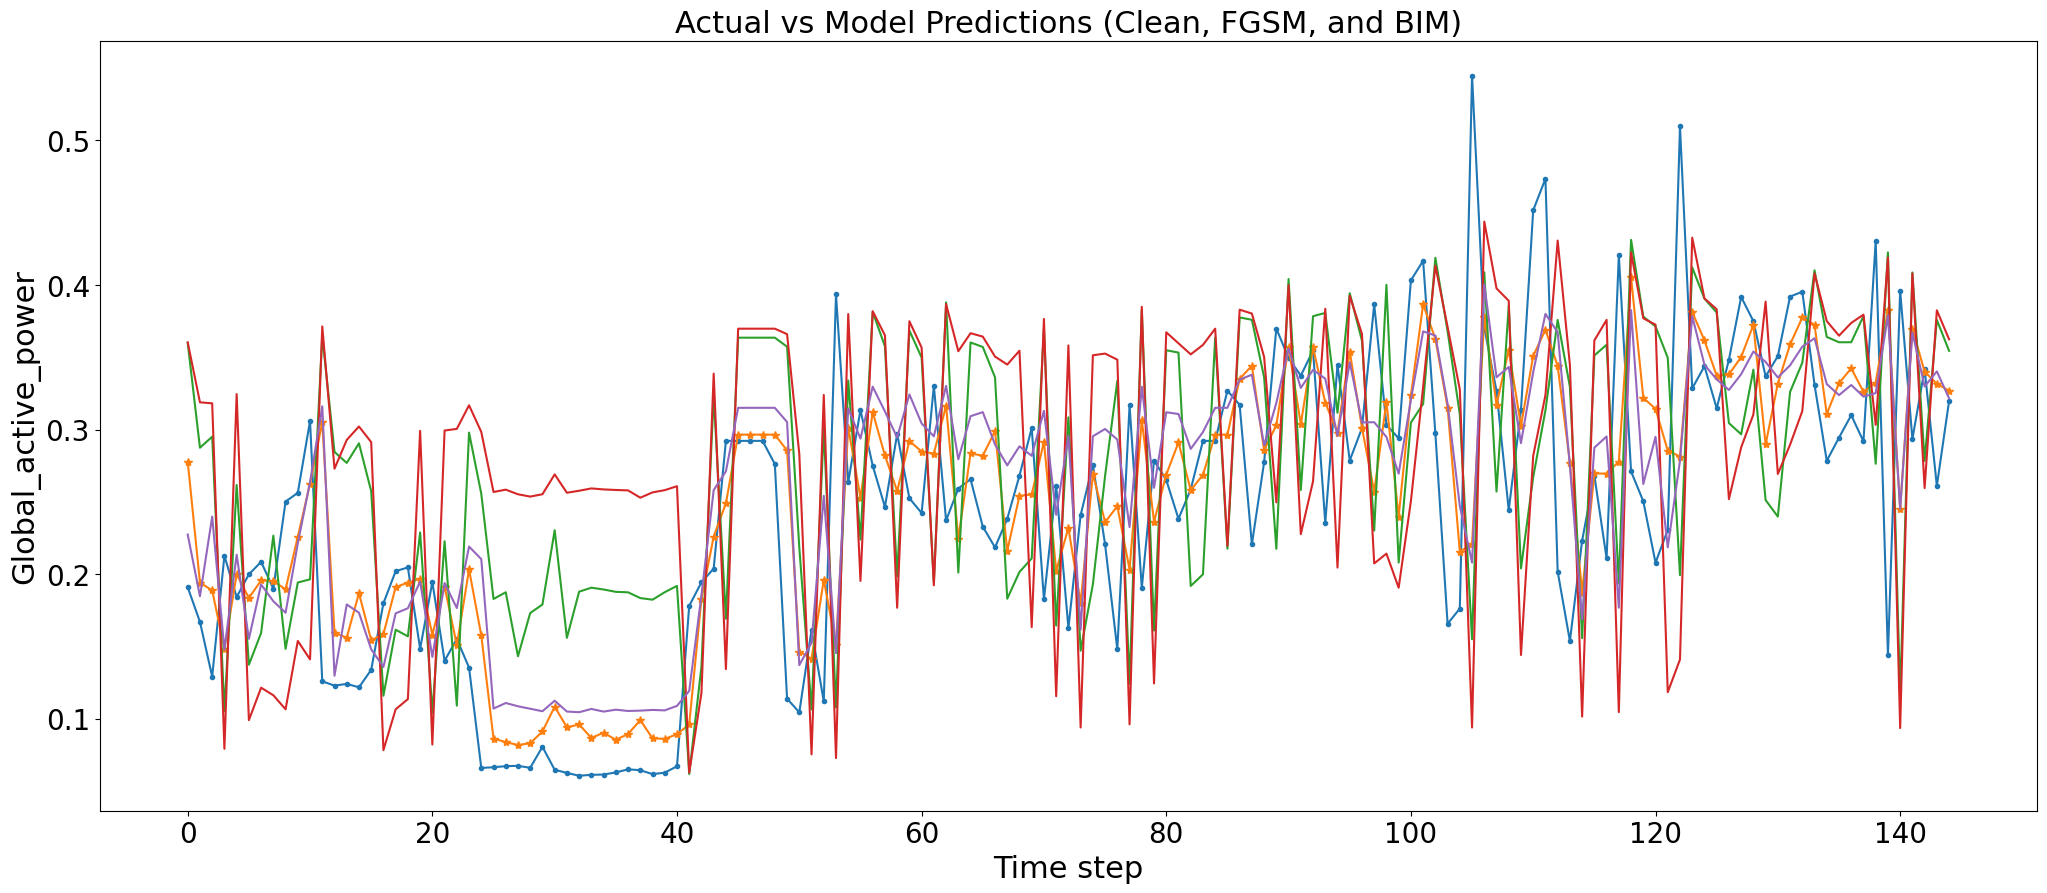

In [ ]:
# Visualize results including BIM attack
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Model Predictions (Clean, FGSM, and BIM)", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Standard Predicted")
plt.plot(range(len(test_pred_advy)), test_pred_advy[:], label="FGSM Attack")
plt.plot(range(len(bim_test_pred_advy)), bim_test_pred_advy[:], label="BIM Attack")
plt.plot(range(len(robust_pred_y_test)), robust_pred_y_test[:], label="FGSM-Robust Predicted")
plt.plot(range(len(robust_bim_pred_y_test)), robust_bim_pred_y_test[:], label="BIM-Robust Predicted")
plt.legend(fontsize=20)
plt.show()

In [ ]:
from tensorflow.keras.losses import MeanSquaredError

Running BIM attack with epsilon = 0.05
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epsilon: 0.05, RMSE: 0.1387, MSE: 0.0192


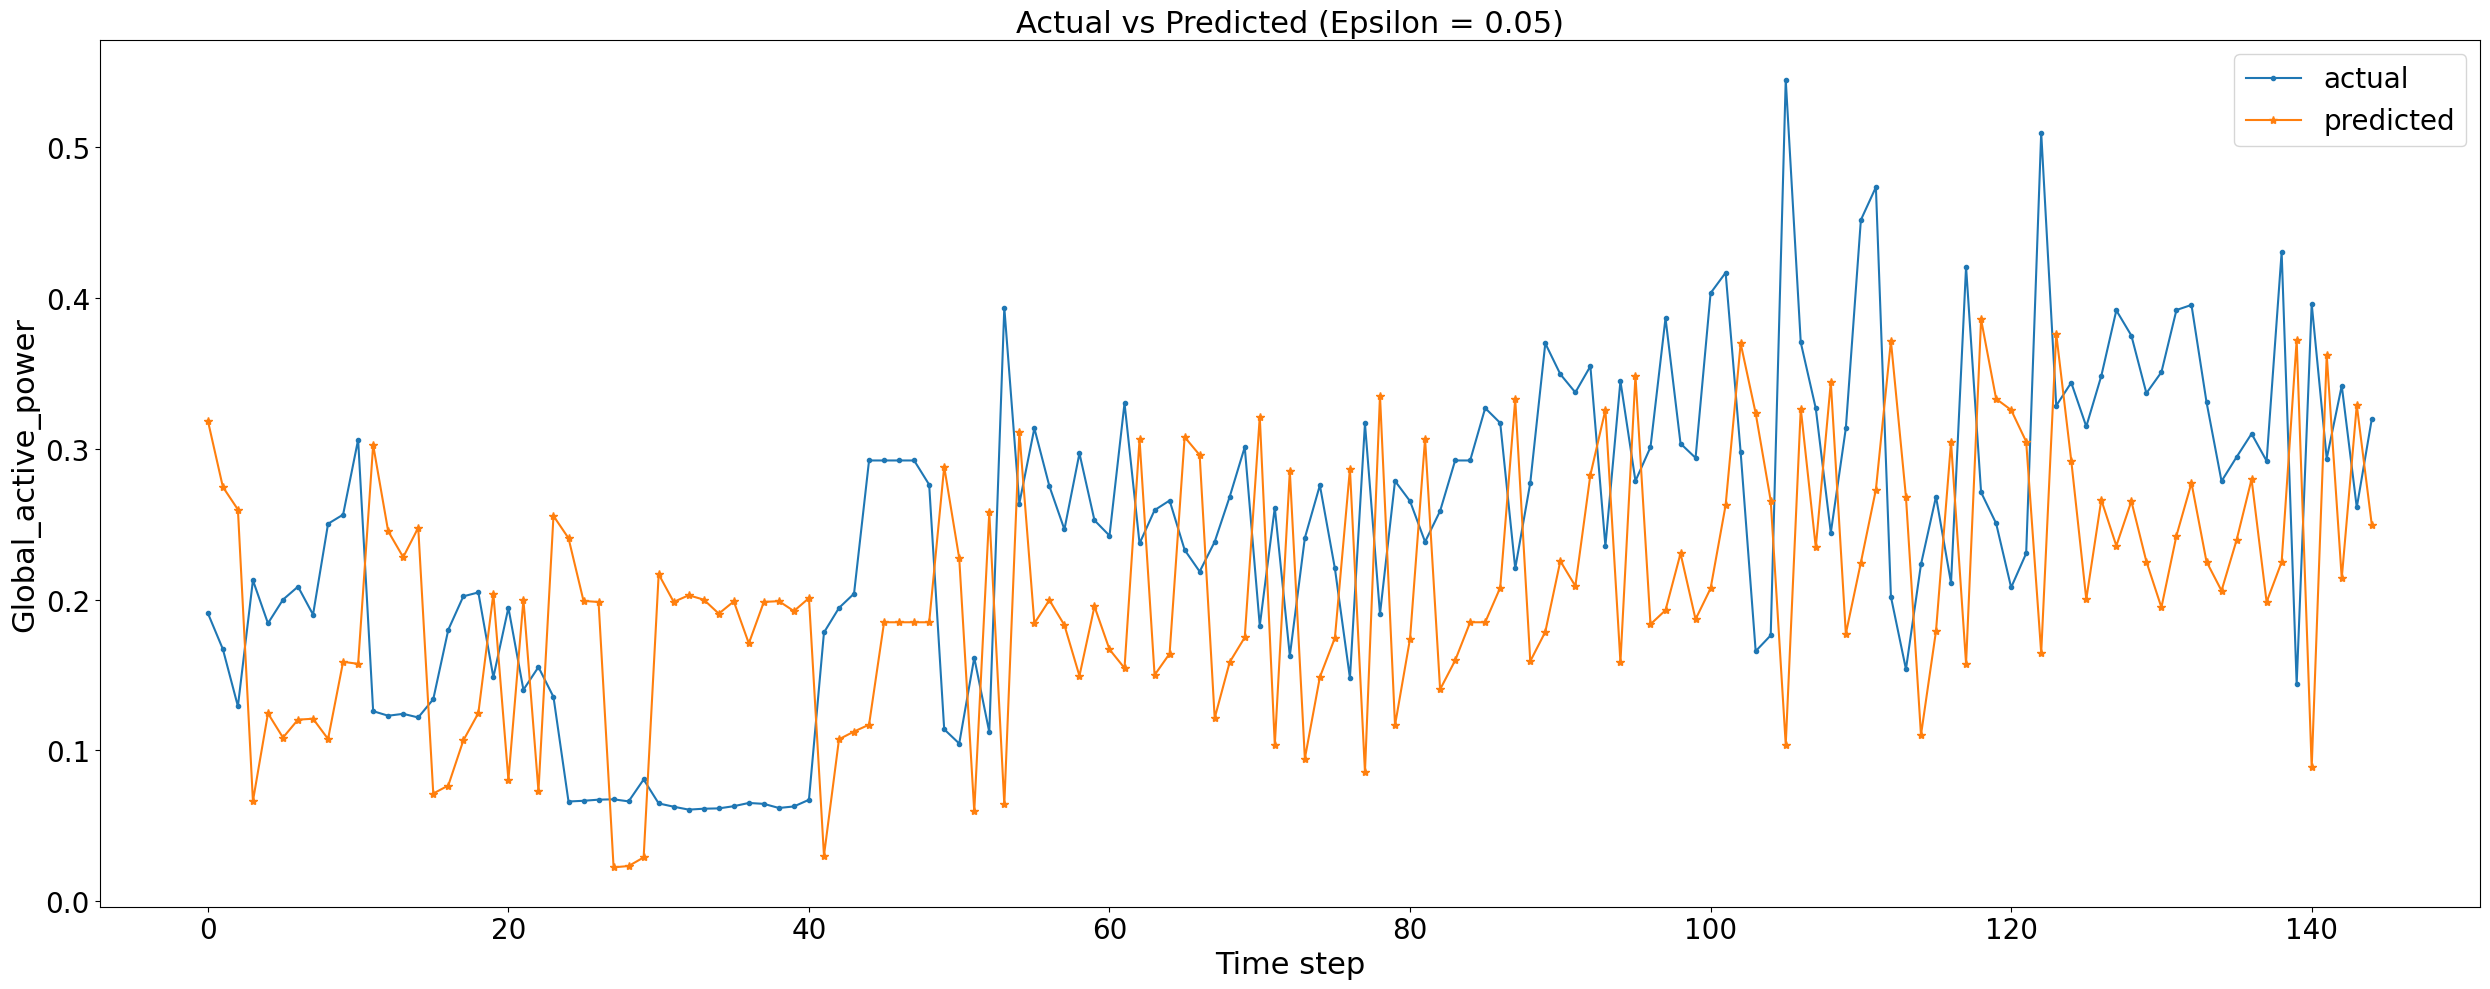

Running BIM attack with epsilon = 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epsilon: 0.1, RMSE: 0.1574, MSE: 0.0248


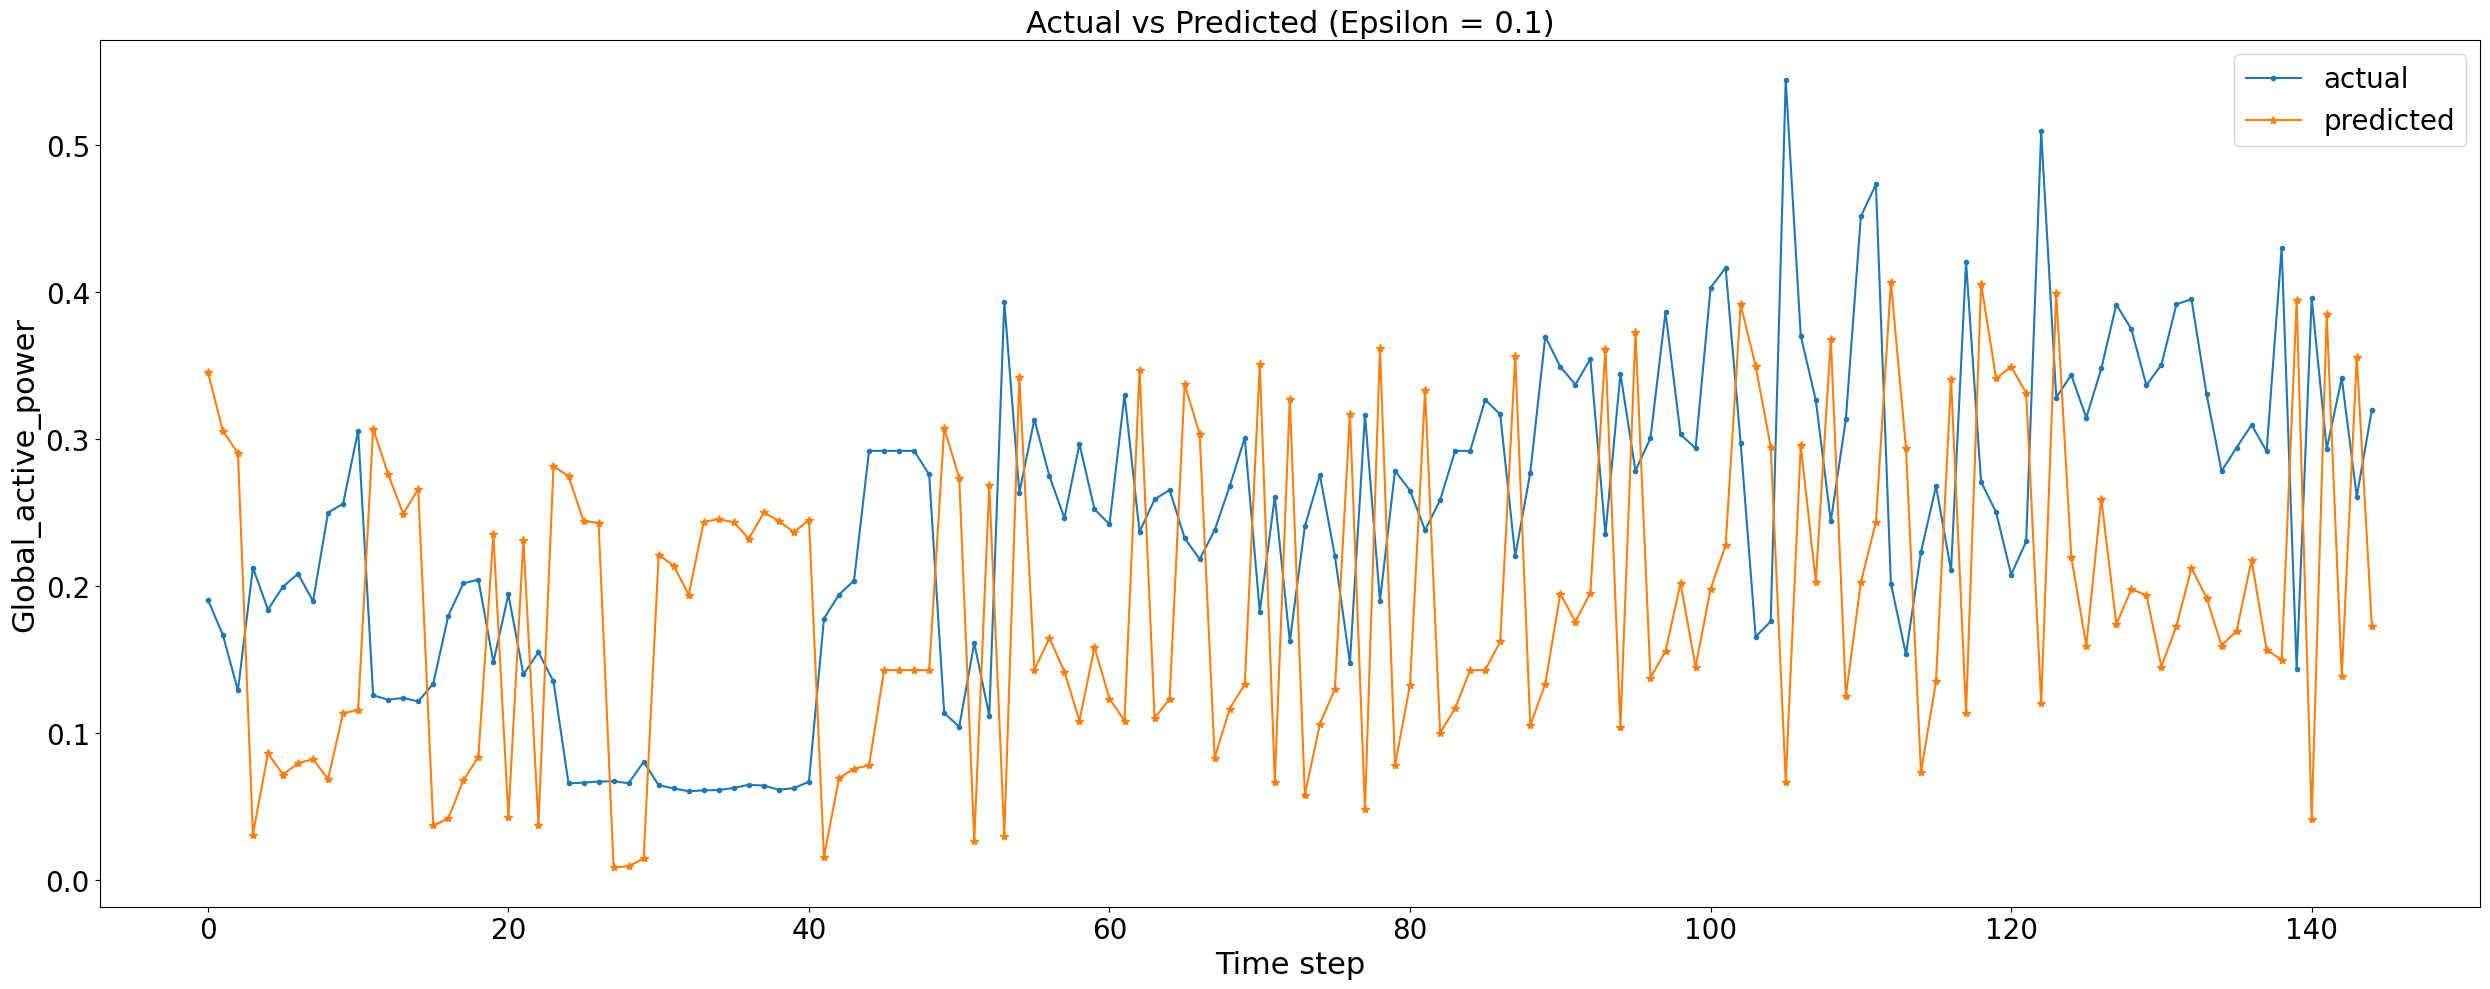

Running BIM attack with epsilon = 0.15


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epsilon: 0.15, RMSE: 0.1574, MSE: 0.0248


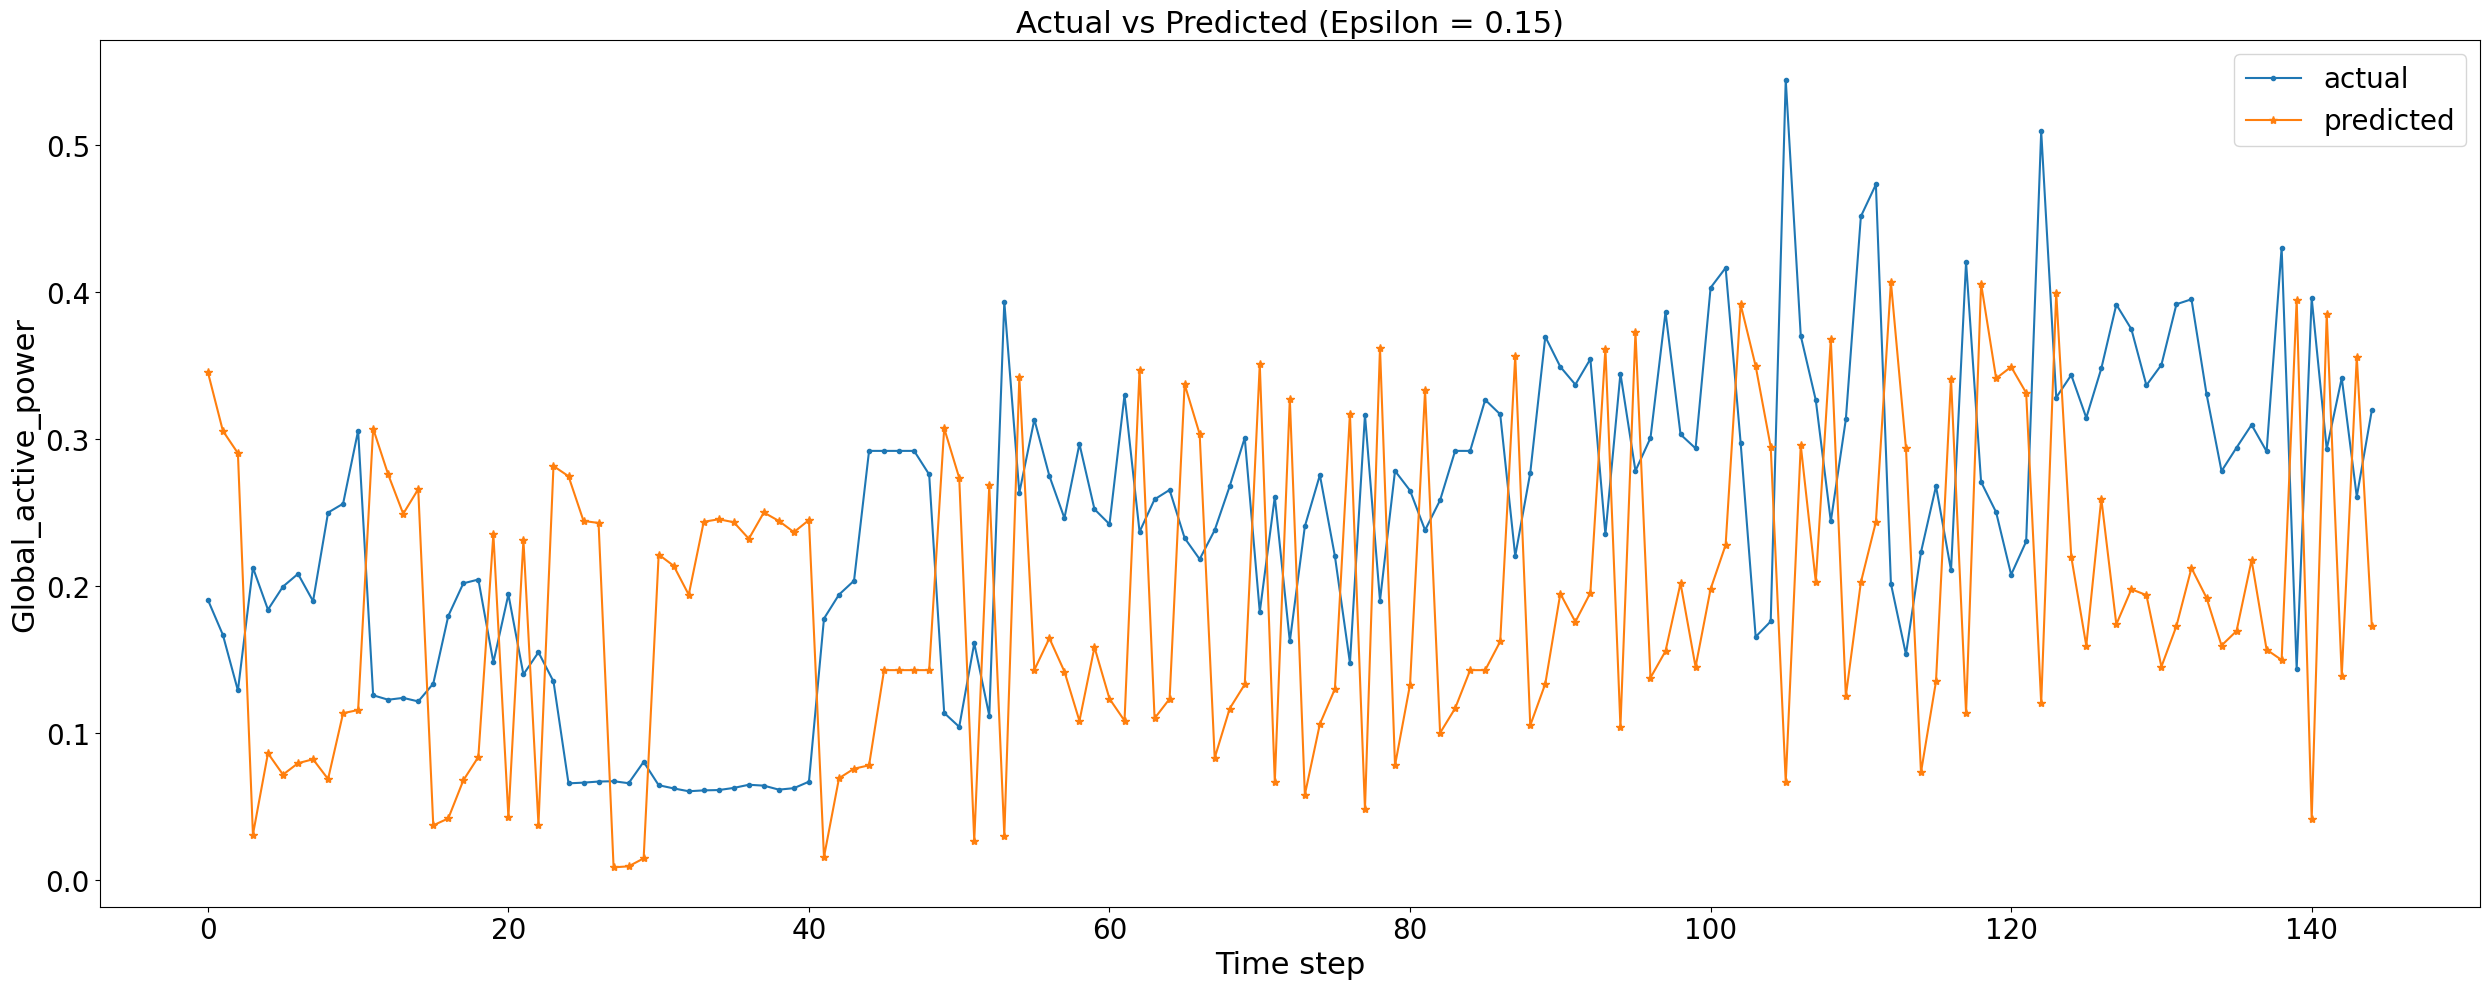

Running BIM attack with epsilon = 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epsilon: 0.2, RMSE: 0.1574, MSE: 0.0248


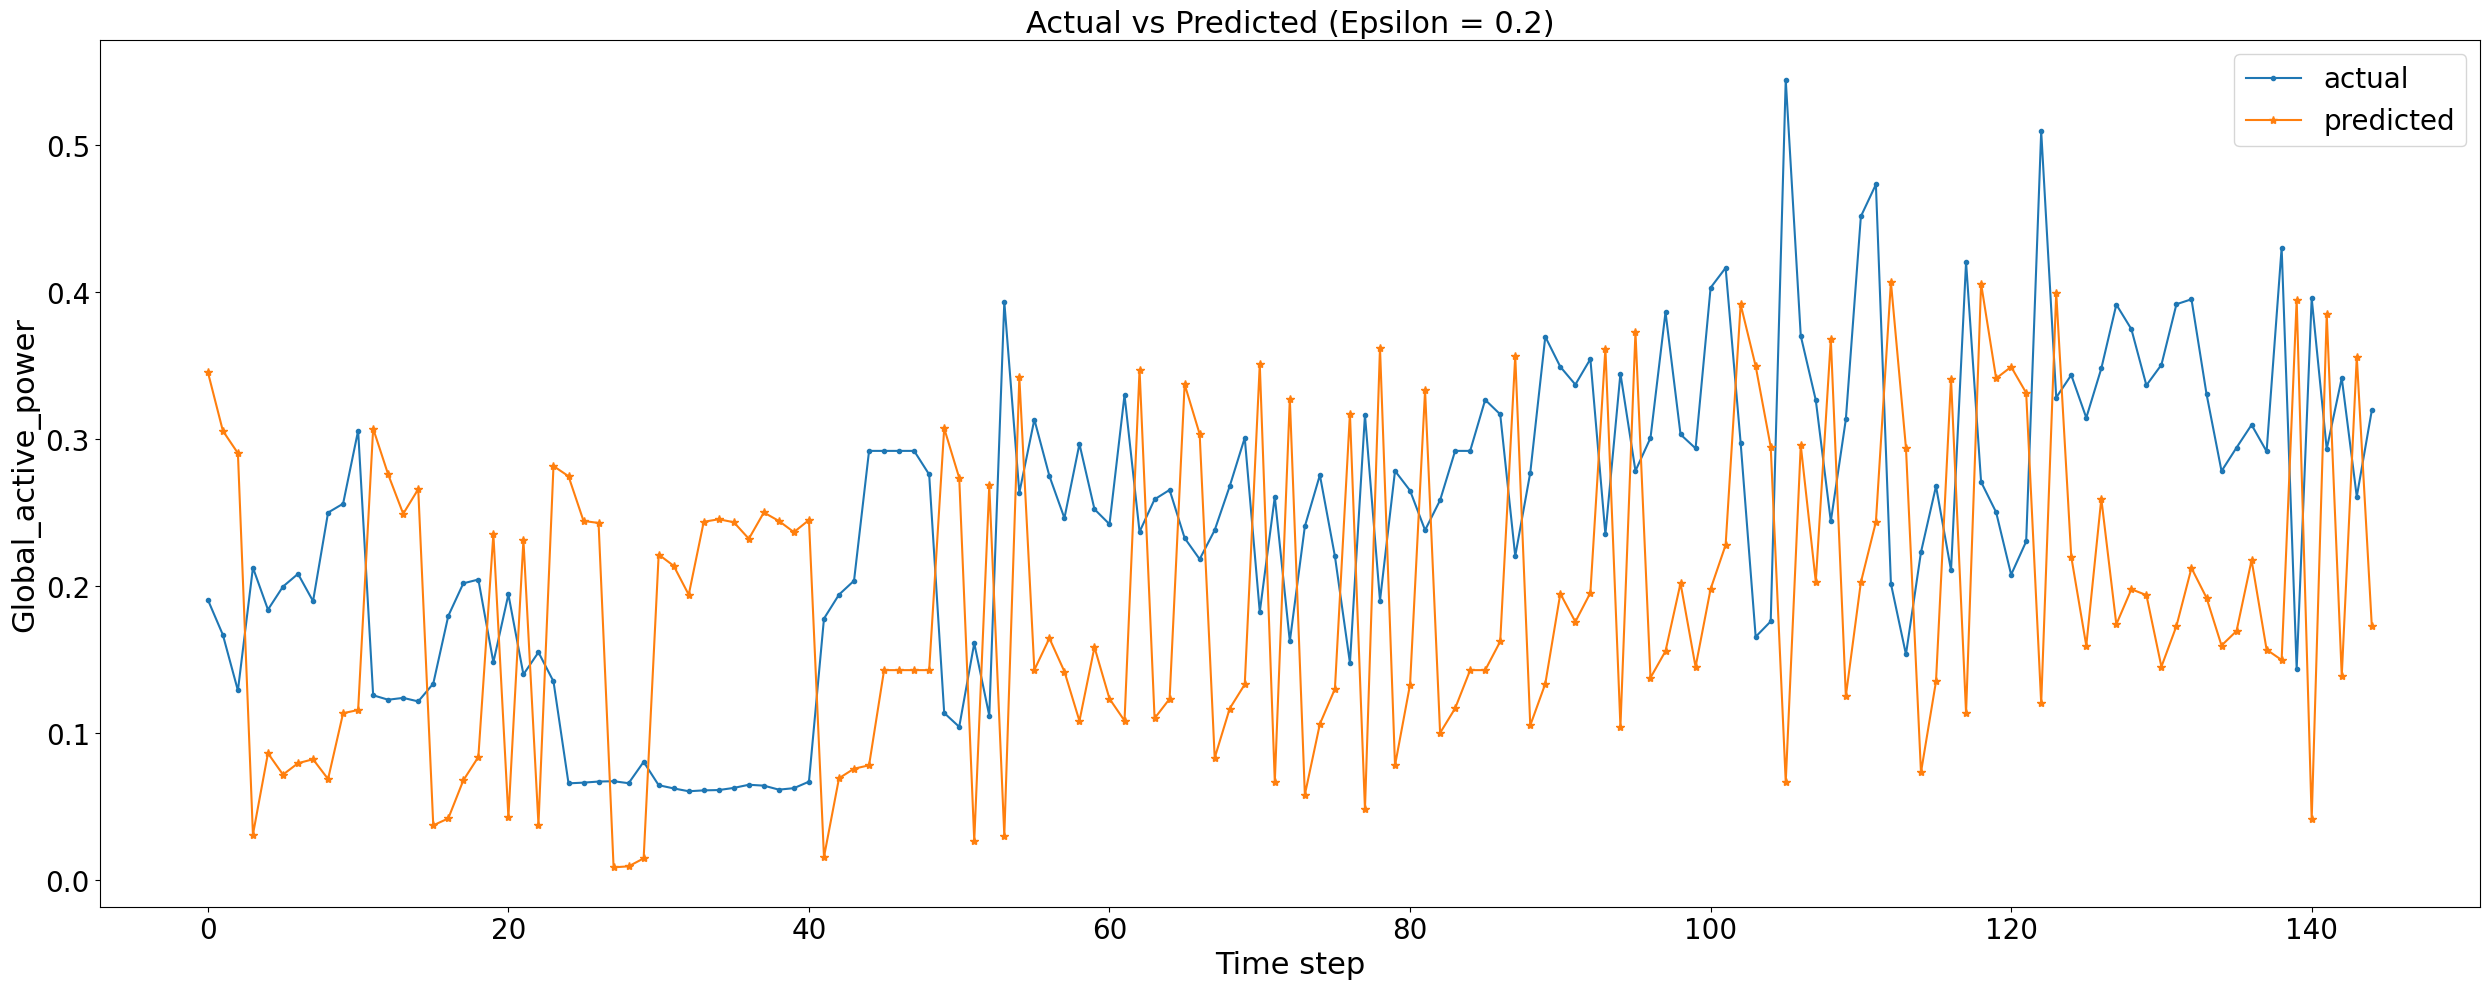

Running BIM attack with epsilon = 0.25


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
# Define epsilon values to test
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
attack_rmse = []
attack_mse = []
attacked_predictions = []

# Run BIM attack for each epsilon value
for epsilon in epsilon_values:
    print(f"Running BIM attack with epsilon = {epsilon}")

    # BIM attack with current epsilon
    advX_bim = bim_attack(robust_bim_model, test_X, test_y, epsilon)

    # Get predictions on adversarial examples
    test_pred_y = robust_bim_model.predict(advX_bim)
    attacked_predictions.append(test_pred_y)

    # Calculate RMSE
    mse = np.mean(np.square(test_y - test_pred_y))
    rmse = np.sqrt(mse)
    attack_rmse.append(rmse)
    attack_mse.append(mse)

    print(f"Epsilon: {epsilon}, RMSE: {rmse:.4f}, MSE: {mse:.4f}")

    # Plot individual attack results
    plt.figure(figsize=(25, 10))
    plt.ylabel('Global_active_power', fontsize=22)
    plt.xlabel('Time step', fontsize=22)
    plt.title(f"Actual vs Predicted (Epsilon = {epsilon})", fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(range(len(test_y)), test_y[:], marker=".", label="actual")
    plt.plot(range(len(test_pred_y)), test_pred_y[:], marker="*", label="predicted")
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.savefig(f'transformer_bim_epsilon_{epsilon}.pdf', format='pdf')
    plt.show()

In [ ]:
# Plot RMSE vs Epsilon
plt.figure(figsize=(9, 9))
plt.ylabel('RMSE', fontsize=18)
plt.xlabel('Epsilon', fontsize=18)
plt.title("RMSE values for varying values of epsilon", fontsize=20)
plt.plot(epsilon_values, attack_rmse, marker=".", linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('transformer_bim_rmse_vs_epsilon.pdf', format='pdf')
plt.show()

In [ ]:
# Compare effectiveness of different attacks
plt.figure(figsize=(15, 8))
plt.ylabel('MSE Loss', fontsize=18)
plt.xlabel('Model and Attack Type', fontsize=18)
plt.title("Attack Effectiveness Comparison", fontsize=20)
attack_results = [
    model.evaluate(test_X, test_y)[0],  # Standard model, clean data
    model.evaluate(advX, test_y)[0],    # Standard model, FGSM attack
    model.evaluate(advX_bim, test_y)[0], # Standard model, BIM attack
    robust_model.evaluate(test_X, test_y)[0],       # FGSM-robust model, clean data
    robust_model.evaluate(advX, test_y)[0],         # FGSM-robust model, FGSM attack
    robust_model.evaluate(advX_bim, test_y)[0],     # FGSM-robust model, BIM attack
    robust_bim_model.evaluate(test_X, test_y)[0],   # BIM-robust model, clean data
    robust_bim_model.evaluate(advX, test_y)[0],     # BIM-robust model, FGSM attack
    robust_bim_model.evaluate(advX_bim, test_y)[0]  # BIM-robust model, BIM attack
]
labels = [
    'Standard\nClean', 'Standard\nFGSM', 'Standard\nBIM',
    'FGSM-Robust\nClean', 'FGSM-Robust\nFGSM', 'FGSM-Robust\nBIM',
    'BIM-Robust\nClean', 'BIM-Robust\nFGSM', 'BIM-Robust\nBIM'
]
plt.bar(labels, attack_results)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display

# Collect all evaluation results
models = ["Standard Model", "FGSM-Robust Model", "BIM-Robust Model"]
test_scenarios = ["Clean Data", "FGSM Attack", "BIM Attack"]

# Create a dictionary with the results
results_dict = {
    "Standard Model": [
        model.evaluate(test_X, test_y)[0],  # Clean data
        model.evaluate(advX, test_y)[0],    # FGSM attack
        model.evaluate(advX_bim, test_y)[0] # BIM attack
    ],
    "FGSM-Robust Model": [
        robust_model.evaluate(test_X, test_y)[0],   # Clean data
        robust_model.evaluate(advX, test_y)[0],     # FGSM attack
        robust_model.evaluate(advX_bim, test_y)[0]  # BIM attack
    ],
    "BIM-Robust Model": [
        robust_bim_model.evaluate(test_X, test_y)[0],  # Clean data
        robust_bim_model.evaluate(advX, test_y)[0],    # FGSM attack
        robust_bim_model.evaluate(advX_bim, test_y)[0] # BIM attack
    ]
}

# Create a DataFrame
results_df = pd.DataFrame(results_dict, index=test_scenarios)

# Format the values to show 4 decimal places
results_df = results_df.applymap(lambda x: f"{x:.4f}")

# Display the table
print("Model Performance Comparison (MSE Loss)")
display(results_df)

# You can also create a table for the percentage increase in loss
base_results = [model.evaluate(test_X, test_y)[0]] * 3  # Base loss for standard model on clean data

# Calculate percentage change compared to clean data for each model
pct_change = {}
for model_name in models:
    base = float(results_dict[model_name][0])  # Clean data loss
    pct_change[model_name] = [
        "0.00%",  # Clean data (reference)
        f"{((float(results_dict[model_name][1]) / base) - 1) * 100:.2f}%",  # FGSM
        f"{((float(results_dict[model_name][2]) / base) - 1) * 100:.2f}%"   # BIM
    ]

# Create percentage change DataFrame
pct_change_df = pd.DataFrame(pct_change, index=test_scenarios)

# Display the table
print("\nPercentage Increase in Loss Compared to Clean Data")
display(pct_change_df)